# Análisis predictivo de series temporales
------

## Análisis exploratorio: regresión entre series, periodograma y regresión no lineal.

In [58]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import astsadata as astsa

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

En el cuaderno anterior vimos el el **Modelo de Regresión Lineal:**

$$x_t = \beta_1z_{t_1} + \ldots + \beta_qz_{t_q} + w_t.$$


En el modelo:

$$x_t = \beta_1z_{t_1} + \ldots + \beta_qz_{t_q} + w_t.$$

* $\beta_1\ldots\beta_q$ son los parámetros a ajustar
* $z_{t_i}$ son las funciones de regresión a usar, evaluadas en cada $t$.
* $w_t$ es ruido blanco (gaussiano) de varianza $\sigma_w^2$. 

Usando el comando `ols` se ajustan modelos lineales como el anterior.

Vimos además algunos de sus usos:

 * Ajustar funciones de tendencia a series temporales.
 * Hacer regresión con "factores" que representen fenómenos especiales (ej: trimestres), (Ejercicio 1).
 * Ajustar componentes periódicas (Ejercicio 2)...más sobre esto en este cuaderno.
 
 
Queremos ahora estudiar:

 * El uso de modelos lineales para hallar relaciones *entre series* que permitan explicar una a partir de otra.
 * Cómo ajustar componentes periódicas o estacionales. En particular cómo determinar sus frecuencias.
 * Algunos casos de regresión no lineal.

## Ejemplo: relación entre mortalidad, temperatura y polución.

El ejemplo, tomado del libro de Shumway, consiste en tres series:

* $M_t = $ mortalidad cardiovascular semanal reportada en Los Angeles durante 10 años.
* $T_t = $ temperatura media registrada en Farenheit.
* $P_t = $ conteo de niveles de partículas en el aire.

Grafiquemos las 3 series:


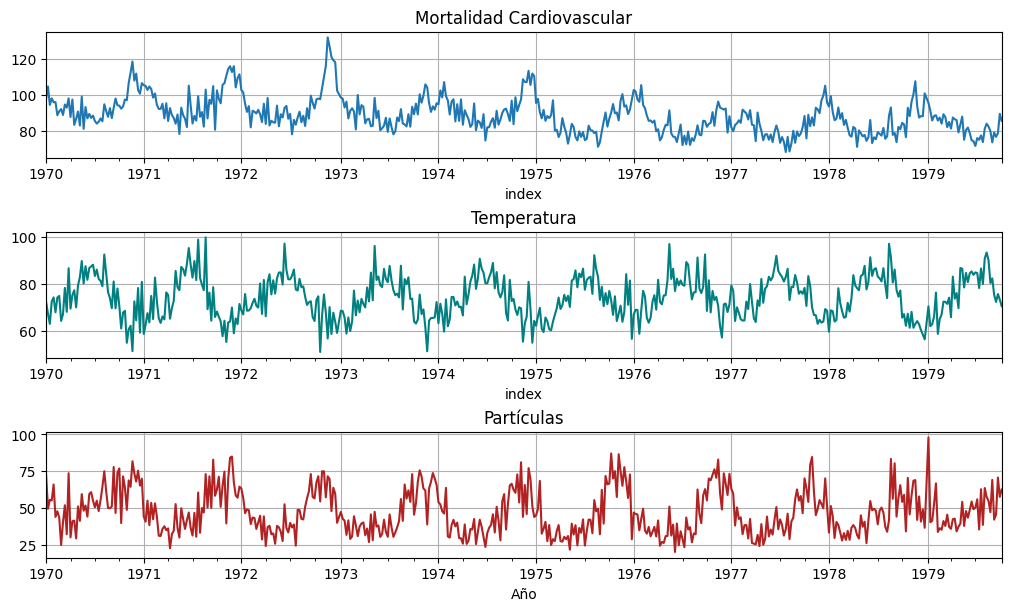

In [2]:
M=astsa.cmort
T=astsa.tempr
P=astsa.part

fig, axs = plt.subplots(3, 1, figsize=[10,6])
M.plot(ax=axs[0], title="Mortalidad Cardiovascular", legend=False)
T.plot(ax=axs[1], title="Temperatura", color="teal", legend=False);
P.plot(ax=axs[2], xlabel="Año", title="Partículas", color="firebrick", legend=False);

### Observaciones:

* Se ve una tendencia decreciente de mortalidad.
* Se ven ciclos estacionales claros (anuales)
* Mortalidad y temperatura parecen estar "en contrafase" -> la gente muere más en invierno?
* Temperatura y partículas parecen estar "en contrafase" también -> la lluvia en invierno limpia?

Para analizar estas relaciones se puede hacer un gráfico de correlaciones, con el comando `pairs` de R.

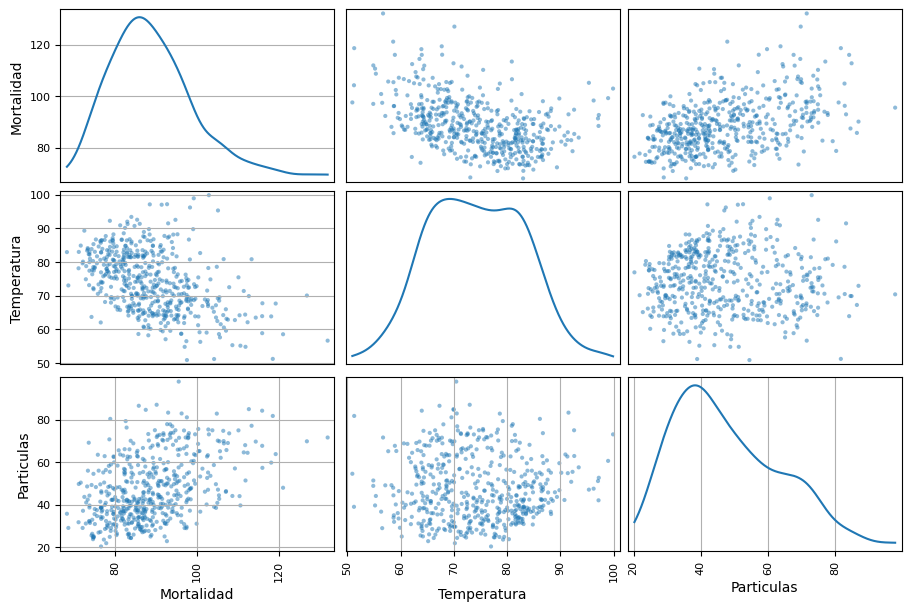

In [3]:
import pandas as pd
import numpy as np
import scipy as sp

pairs = pd.concat([M, T, P], axis=1)
pairs.columns = ["Mortalidad", "Temperatura", "Particulas"]

pd.plotting.scatter_matrix(pairs, figsize=(9, 6), diagonal="kde") #kde pone estimaciones de la densidad en la diagonal
plt.show()

Se propone entonces ajustar algunos modelos que buscan explicar la serie de mortalidad *a partir de las otras*:

1. $M_t = \beta_0 + \beta_1 t + w_t.$
2. $M_t = \beta_0 + \beta_1 t + \beta_2(T_t - \bar{T}) + w_t.$
3. $M_t = \beta_0 + \beta_1 t + \beta_2(T_t - \bar{T}) + \beta_3(T_t - \bar{T})^2 + w_t.$
4. $M_t = \beta_0 + \beta_1 t + \beta_2(T_t - \bar{T}) + \beta_3(T_t - \bar{T})^2 + \beta_4 P_t + w_t.$


#### Modelo 1

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

time = pd.Series([idx.ordinal for idx in M.index], index=M.index, name="Semana")
datos = pd.concat([time,M], axis=1)
datos.columns = ["Semana","Mortalidad"]

fit = ols(formula="M~Semana", data=datos).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     135.0
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           8.03e-28
Time:                        17:02:37   Log-Likelihood:                -1829.9
No. Observations:                 508   AIC:                             3664.
Df Residuals:                     506   BIC:                             3672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     96.6510      0.790    122.335      0.0

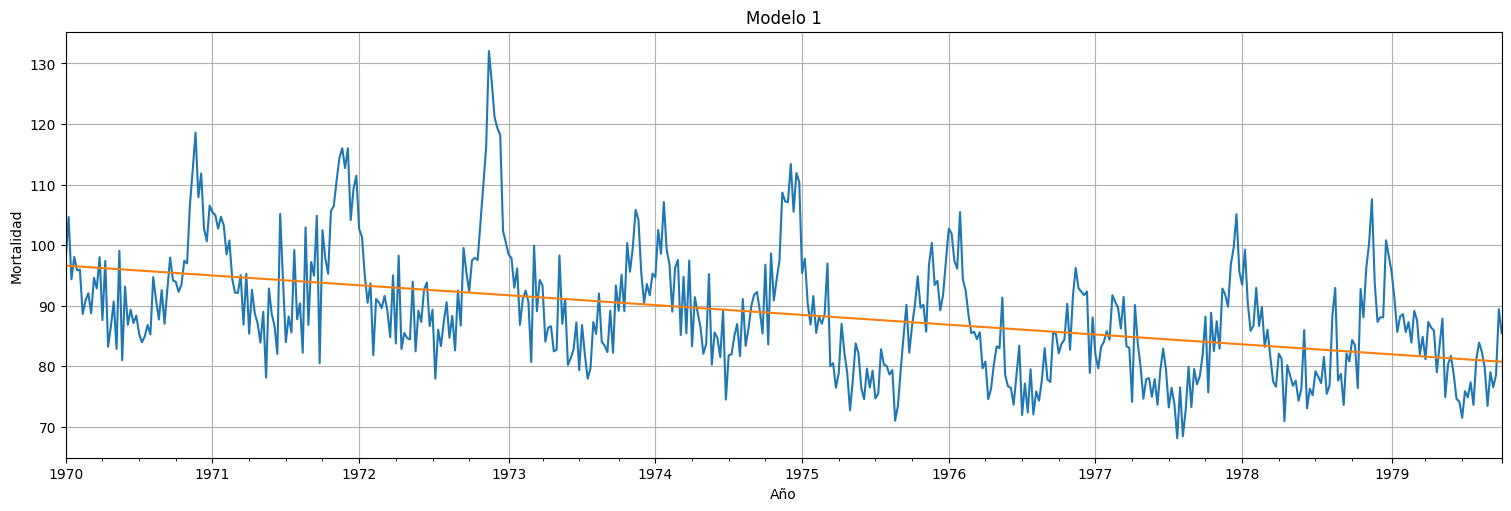

In [5]:
ax = M.plot(xlabel="Año", ylabel="Mortalidad", legend=False)
ax.plot(fit.fittedvalues)
plt.title("Modelo 1")
plt.ylabel("Mortalidad")
plt.xlabel("Año");

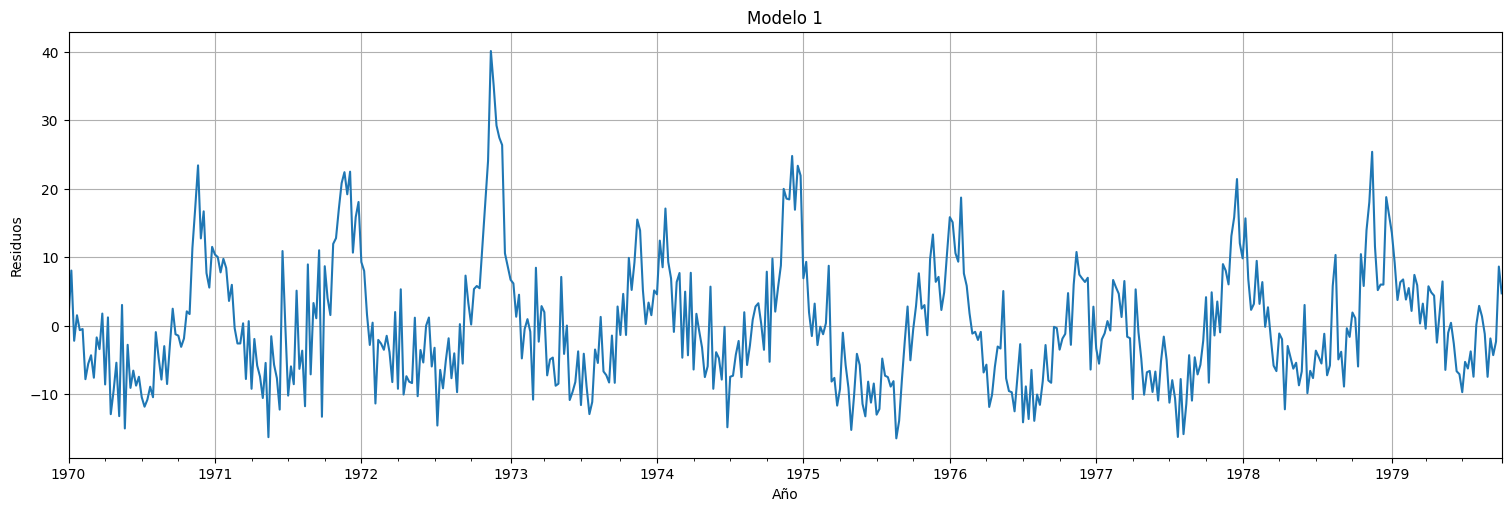

In [6]:
fit.resid.plot()
plt.title("Modelo 1")
plt.ylabel("Residuos")
plt.xlabel("Año");

#### Modelo 2

In [7]:
#  Modelo 2
temp  = T-np.mean(T)           # temperatura centrada

datos = pd.concat([time,M, temp], axis=1)
datos.columns = ["Semana","Mortalidad", "Temperatura"]

fit = ols(formula="M~Semana+Temperatura", data=datos).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     155.0
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           3.28e-53
Time:                        17:02:38   Log-Likelihood:                -1768.4
No. Observations:                 508   AIC:                             3543.
Df Residuals:                     505   BIC:                             3555.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      96.2251      0.702    137.154      

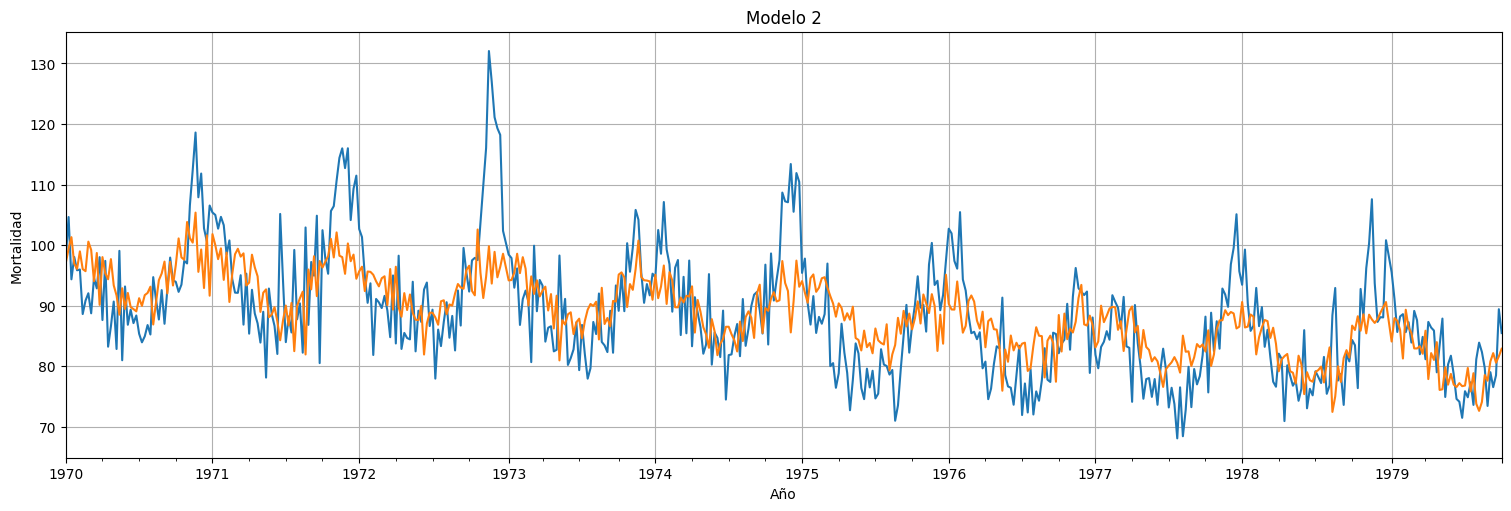

In [8]:
ax = M.plot(xlabel="Año", ylabel="Mortalidad", legend=False)
ax.plot(fit.fittedvalues)
plt.title("Modelo 2")
plt.ylabel("Mortalidad")
plt.xlabel("Año");

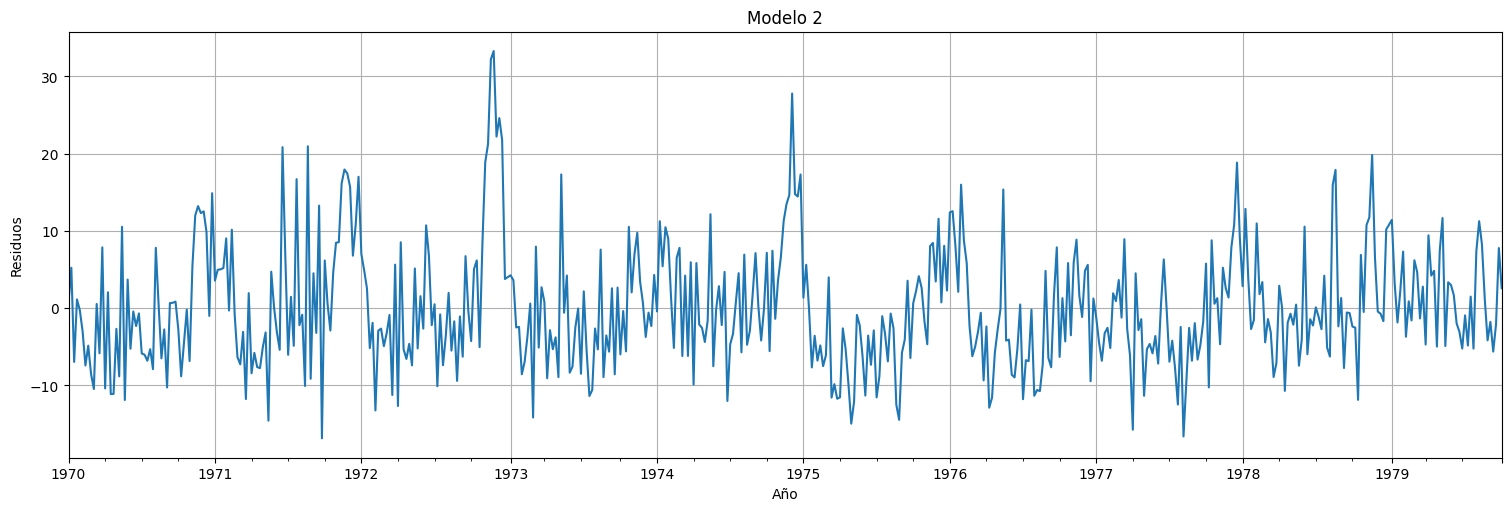

In [9]:
fit.resid.plot()
plt.title("Modelo 2")
plt.ylabel("Residuos")
plt.xlabel("Año");

#### Modelo 3

In [10]:
temp2 = temp**2              # cuadrados

datos = pd.concat([time,M, temp, temp2], axis=1)
datos.columns = ["Semana","Mortalidad", "Temperatura", "Temperatura2"]

fit = ols(formula="M~Semana+Temperatura+Temperatura2", data=datos).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     136.3
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.14e-64
Time:                        17:02:38   Log-Likelihood:                -1739.1
No. Observations:                 508   AIC:                             3486.
Df Residuals:                     504   BIC:                             3503.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       93.9179      0.725    129.543   

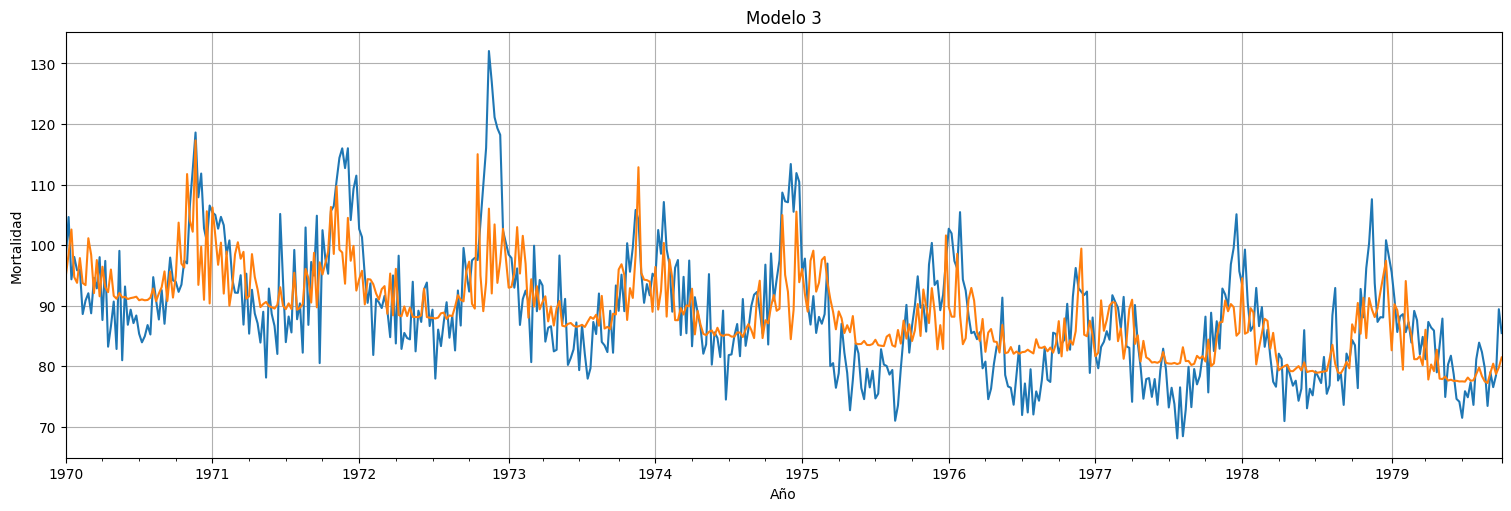

In [11]:
ax = M.plot(xlabel="Año", ylabel="Mortalidad", legend=False)
ax.plot(fit.fittedvalues)
plt.title("Modelo 3")
plt.ylabel("Mortalidad")
plt.xlabel("Año");

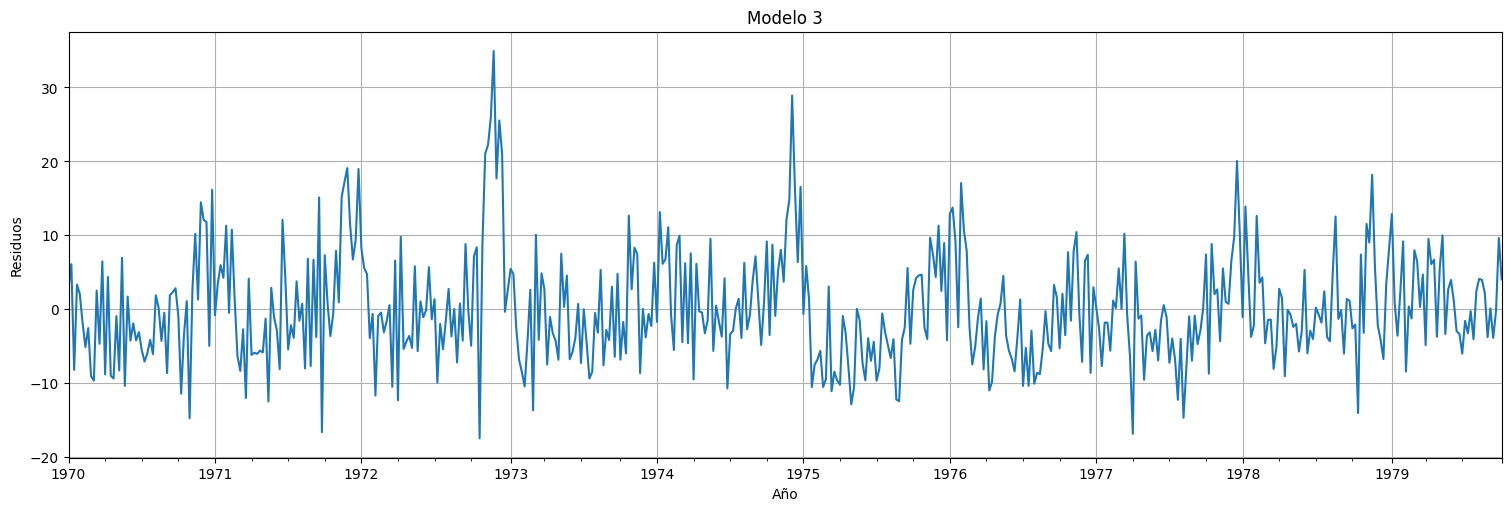

In [12]:
fit.resid.plot()
plt.title("Modelo 3")
plt.ylabel("Residuos")
plt.xlabel("Año");

#### Modelo 4

In [13]:
datos = pd.concat([time,M, temp, temp2, P], axis=1)
datos.columns = ["Semana","Mortalidad", "Temperatura", "Temperatura2", "Particulas"]

fit = ols(formula="M~Semana+Temperatura+Temperatura2+Particulas", data=datos).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     185.1
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           2.20e-97
Time:                        17:02:39   Log-Likelihood:                -1660.1
No. Observations:                 508   AIC:                             3330.
Df Residuals:                     503   BIC:                             3351.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       81.5931      1.102     74.032   

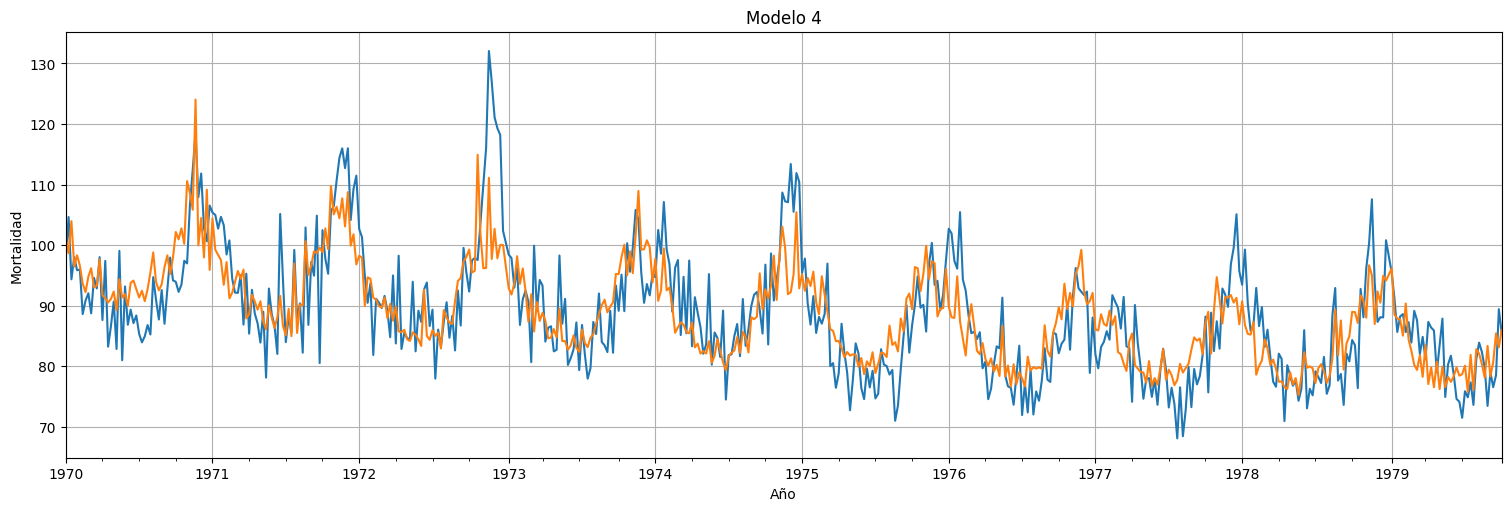

In [14]:
ax = M.plot(xlabel="Año", ylabel="Mortalidad", legend=False)
ax.plot(fit.fittedvalues)
plt.title("Modelo 4")
plt.ylabel("Mortalidad")
plt.xlabel("Año");

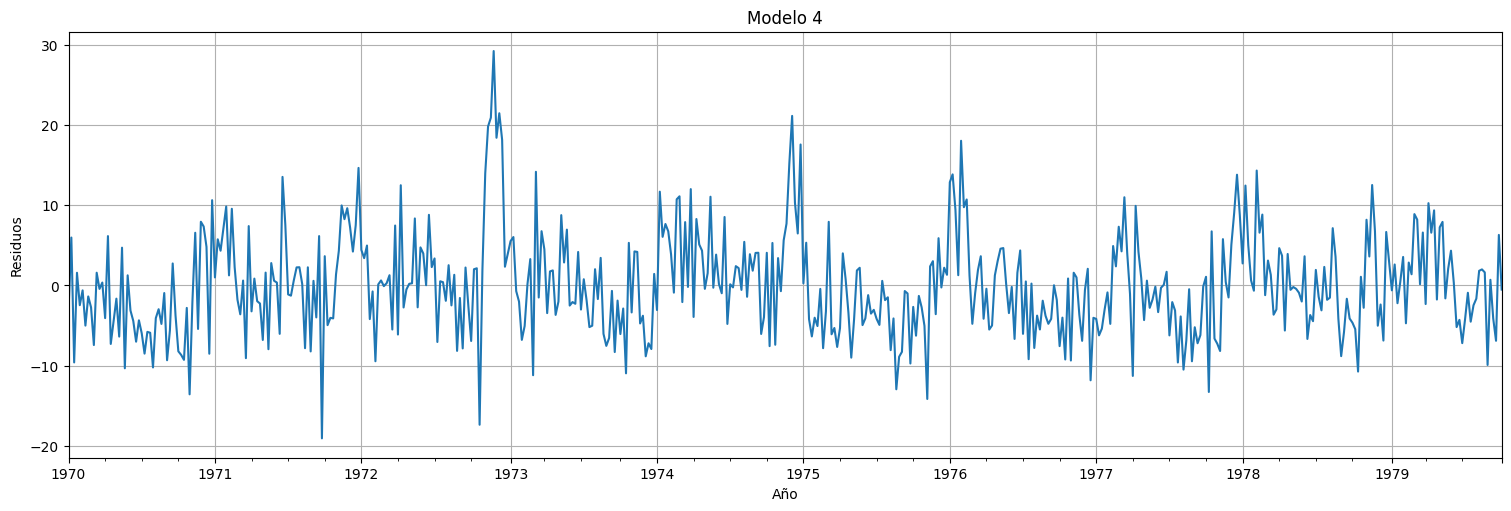

In [15]:
fit.resid.plot()
plt.title("Modelo 4")
plt.ylabel("Residuos")
plt.xlabel("Año");

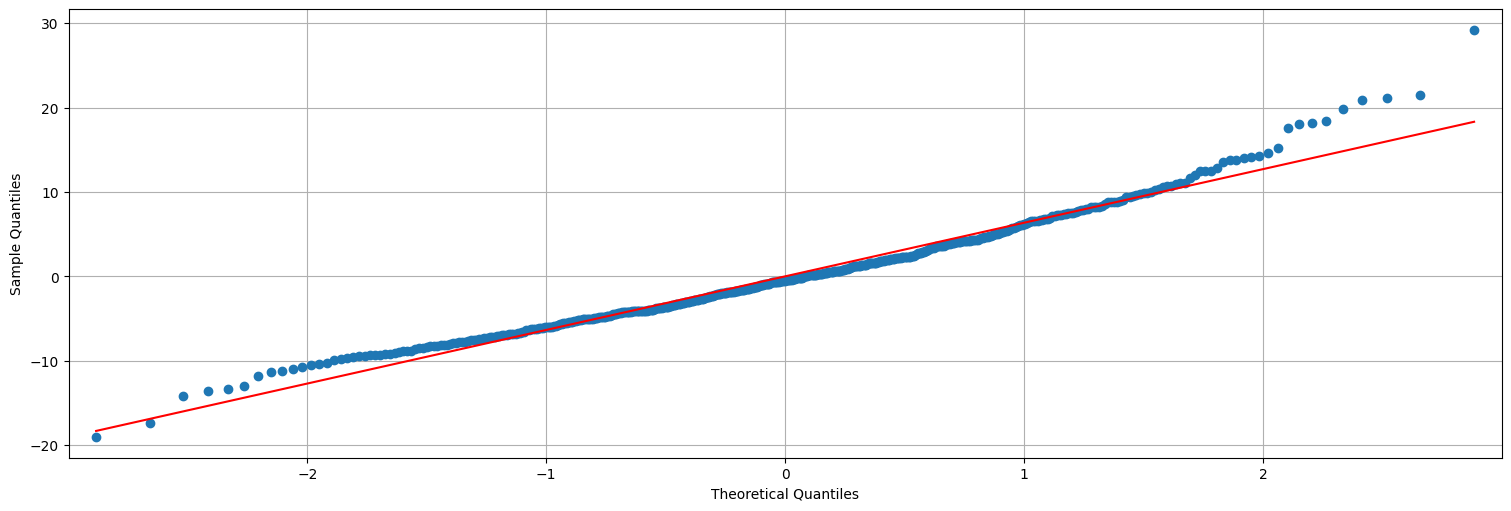

In [16]:
## QQ-plot es una verificación de gaussianidad.
sm.qqplot(fit.resid, line="s");

#### Nota:
Para calcular la acf, conviene utilizar `statsmodels.tsa.graphics.plot_acf()` con la opción `bartlett_confint=False` para usar el intervalo de confianza correcto

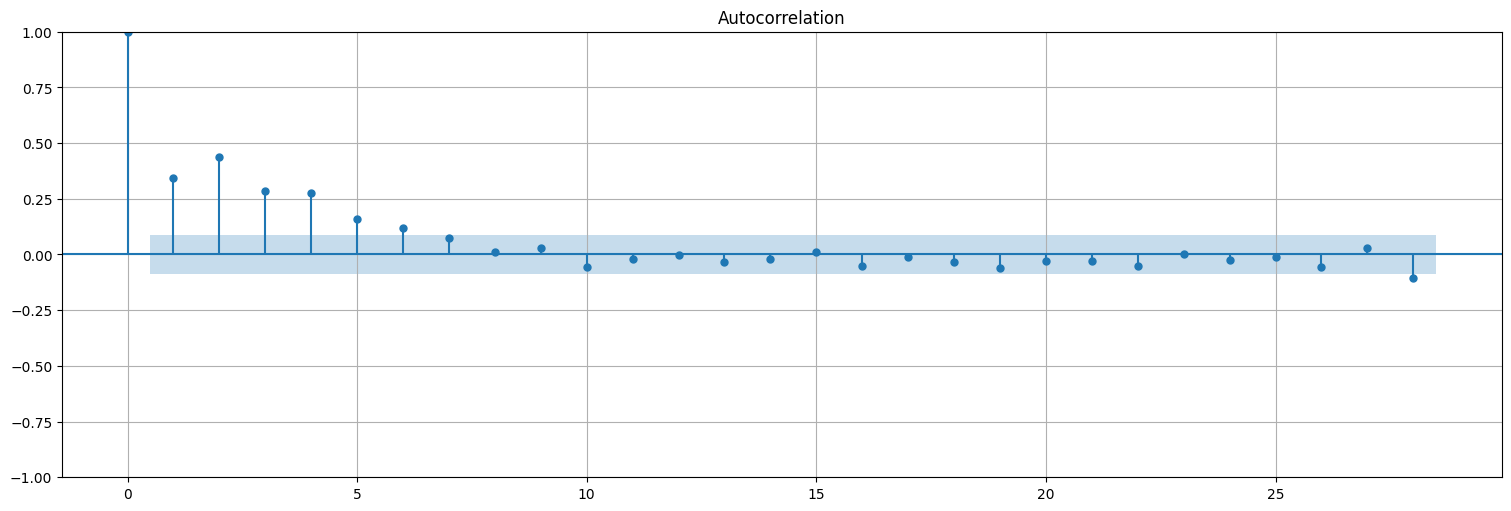

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(fit.resid, bartlett_confint=False);

Agreguemos ahora un modelo donde usamos también la variable $P_t^2$ además de $P_t$, para ver cómo el modelo comienza a empeorar en términos del $AIC/BIC$.

In [18]:
#  Modelo 5 (para ver que el AIC/BIC empeora)
P2 = P**2                    # particulas al cuadrado

datos = pd.concat([time,M, temp, temp2, P, P2], axis=1)
datos.columns = ["Semana","Mortalidad", "Temperatura", "Temperatura2", "Particulas", "Particulas2"]

fit = ols(formula="M~Semana+Temperatura+Temperatura2+Particulas+Particulas2", data=datos).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     148.2
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           2.06e-96
Time:                        17:02:40   Log-Likelihood:                -1659.7
No. Observations:                 508   AIC:                             3331.
Df Residuals:                     502   BIC:                             3357.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       78.9871      2.987     26.445   

## Ejemplo: Regresión con "lag".

En clases anteriores vimos (a ojo) que existe una relación entre el índice del niño (Southern oscillation index, SOI) y la población de peces (Recruitement).

Recordemos las series:

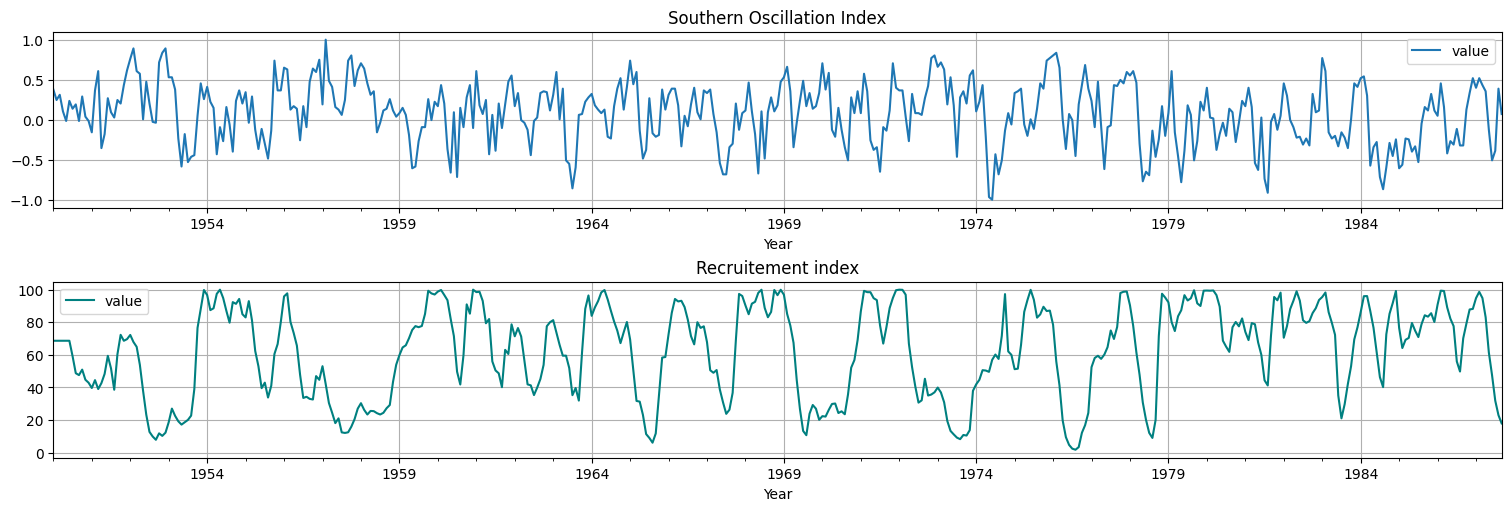

In [19]:
soi = astsa.soi
rec = astsa.rec

fig, axs = plt.subplots(2, 1, constrained_layout = True)
soi.plot(ax=axs[0], xlabel="Year", title="Southern Oscillation Index")
rec.plot(ax=axs[1], xlabel="Year", title="Recruitement index", color="teal");

Analicemos la autocorrelación de cada serie, y la correlación cruzada:

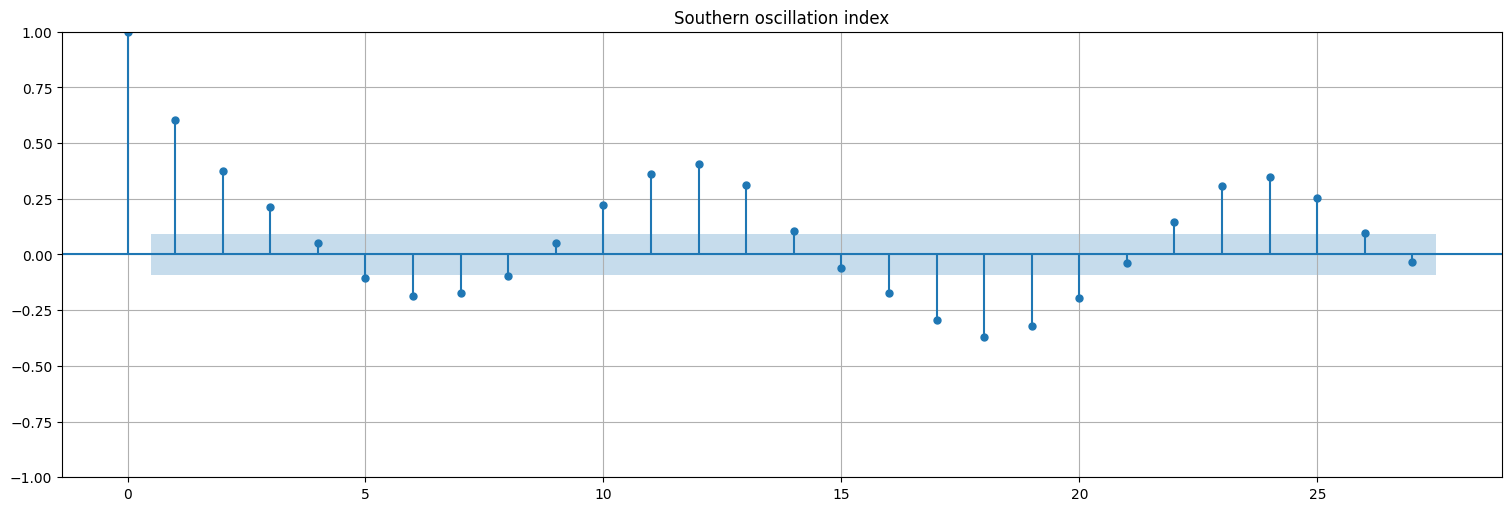

In [20]:
plot_acf(soi, bartlett_confint=False);
plt.title("Southern oscillation index");

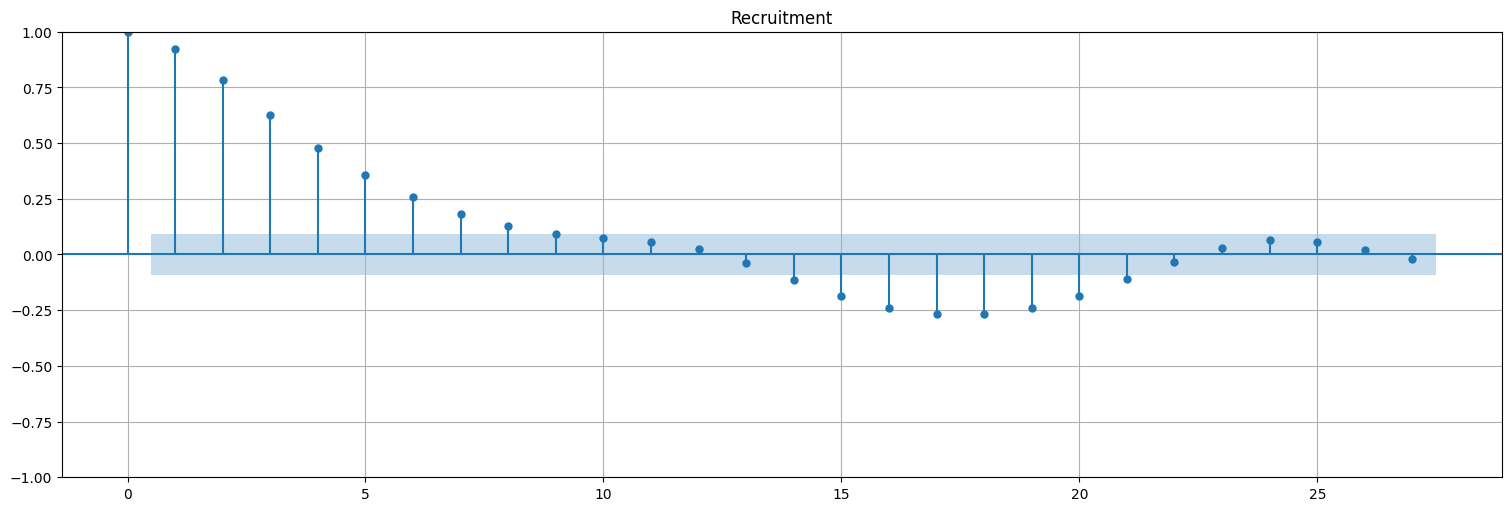

In [21]:
plot_acf(rec, bartlett_confint=False)
plt.title("Recruitment");

### Nota:
Esta función grafica la correlación cruzada de manera adecuada

In [22]:
def ccf(x, y, max_lag, ax=None, **kwargs):
    lags = np.arange(-max_lag, max_lag + 1)

    backwards = sm.tsa.ccf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
    forwards = sm.tsa.ccf(x, y, adjusted=False)[:max_lag + 1]
    ccf = np.r_[backwards[:-1], forwards]
    ylabel = "CCF"

    if ax is None:
        ax = plt.gca()
    
    ax.stem(lags, ccf, basefmt="k")
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    conf_level = 1.96 / np.sqrt(x.shape[0])
    ax.fill_between(lags,conf_level,-conf_level,alpha=0.25)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    
    return ax

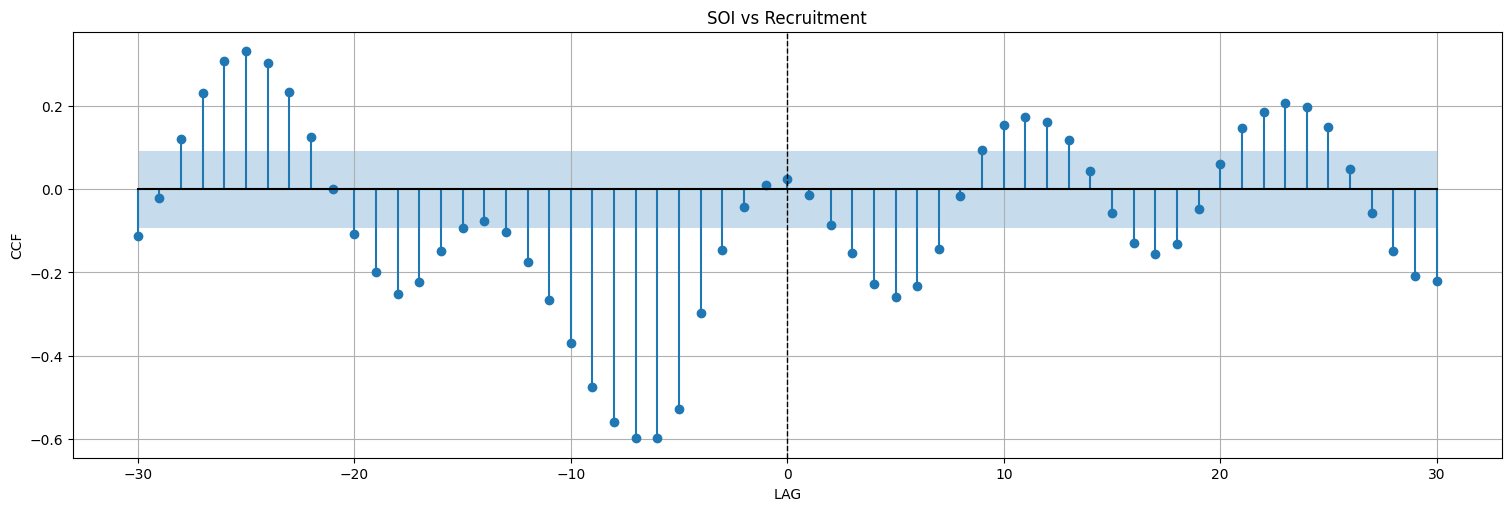

In [23]:
ccf(soi,rec, max_lag=30)
plt.title("SOI vs Recruitment");

### Observaciones:

* La serie del SOI muestra correlaciones fuertes cada 12 meses.
* El libro dice que la de recruitement también pero yo no las veo (más adelante retomamos esto).
* La correlación cruzada tiene un pico (negativo) en -6 meses. Esto indica que la serie SOI puede predecir la serie de Recruitement usando el valor de 6 meses antes.

Se propone entonces un modelo de la forma:

$$R_t = \beta_0 + \beta_1 S_{t−6} + w_t.$$

Es decir, estimar el recruitement actual por una media más algo que depende del SOI 6 meses antes. Observemos que esto es un modelo lineal como antes, donde simplmente figuran como "features" el intercept u ordenada en el origen, y los valores de $S$ corridos.

*Problema:* ¿como logramos alinear la serie $R_t$ en tiempo $t$ y la serie $S_{t-6}$ laggeada?

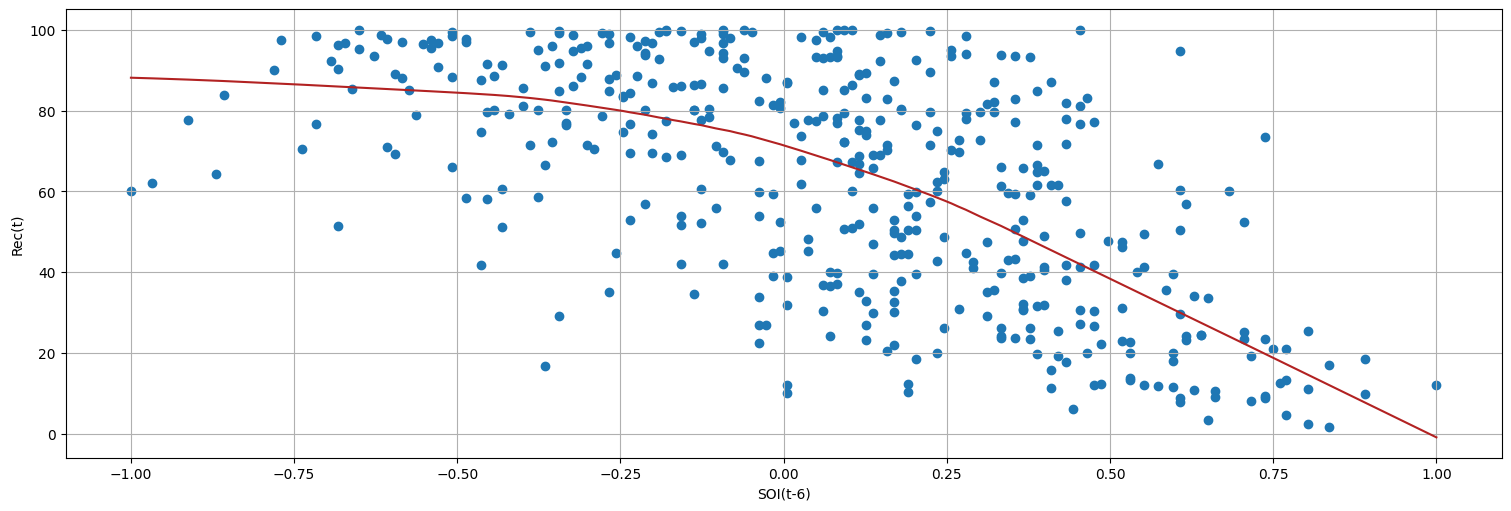

In [24]:
lag=6
plt.scatter(soi.shift(lag), rec);
#Agrego un suavizado local para ver la tendencia
lowess = sm.nonparametric.lowess(rec.iloc[:, 0], soi.iloc[:, 0].shift(lag))
plt.plot(lowess[:, 0], lowess[:, 1], color="firebrick");
plt.xlabel("SOI(t-6)")
plt.ylabel("Rec(t)");

In [25]:
#Podemos llamar a fit haciendo referencia a las columnas del dataframe (fish en este caso).
fish = pd.concat([rec, soi.shift(6)], axis=1).dropna()
fish.columns = ["rec", "soiL6"]

fit = ols("rec ~ soiL6", data=fish).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    rec   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     253.5
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.68e-45
Time:                        17:02:42   Log-Likelihood:                -2024.9
No. Observations:                 447   AIC:                             4054.
Df Residuals:                     445   BIC:                             4062.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     65.7898      1.088     60.469      0.0

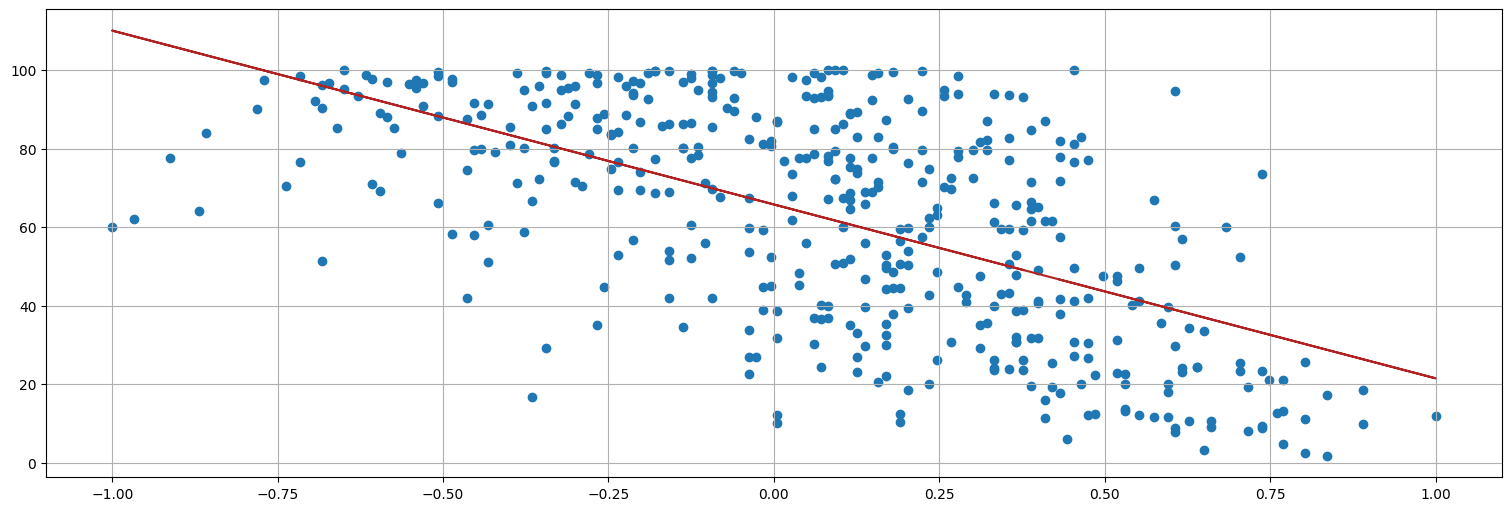

In [26]:
plt.plot(fish.soiL6,fit.fittedvalues, color="firebrick")
plt.scatter(soi.shift(lag), rec);

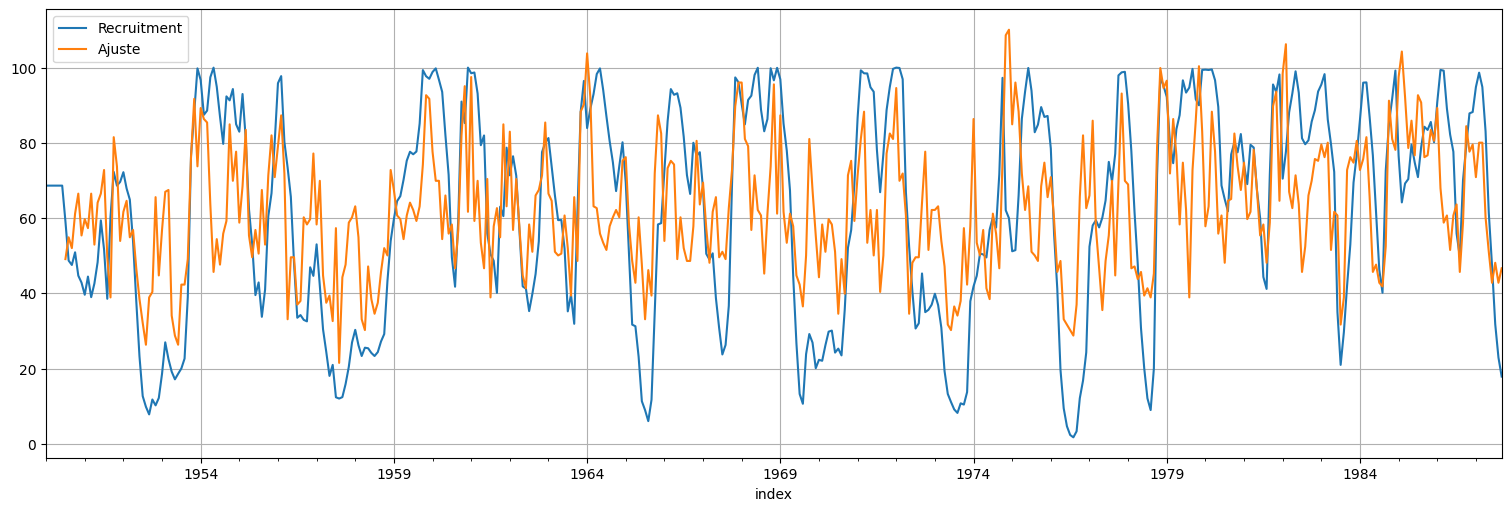

In [27]:
rec.plot()
fit.fittedvalues.plot().legend(["Recruitment","Ajuste"]);

### Análisis de residuos del ajuste

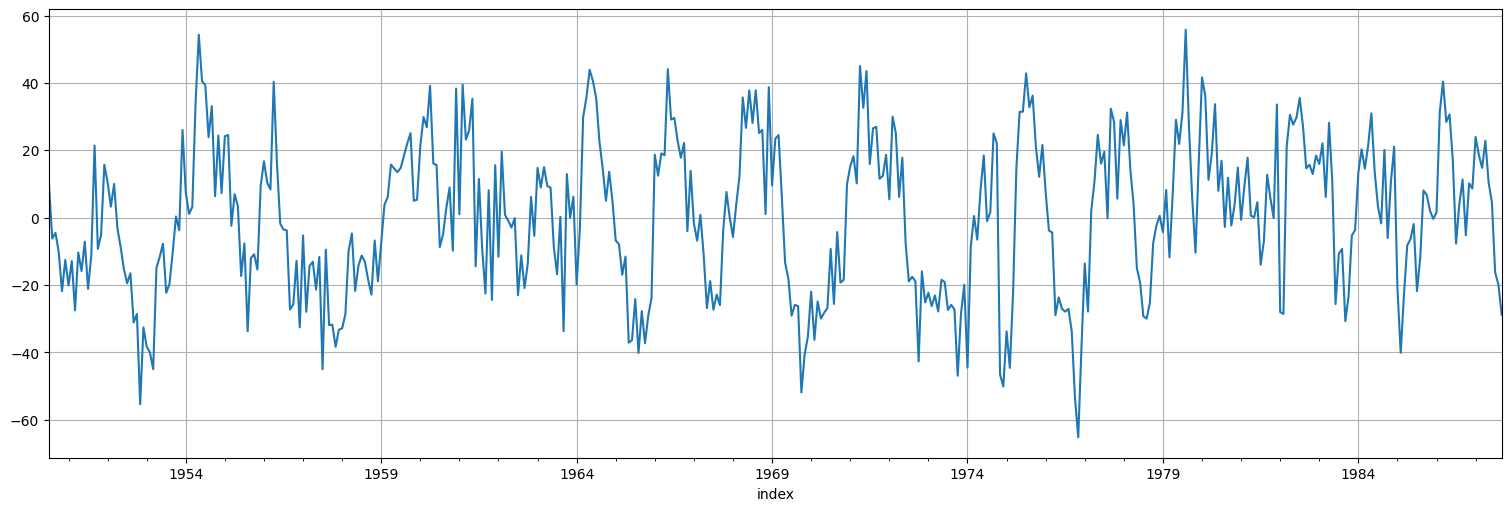

In [28]:
fit.resid.plot();

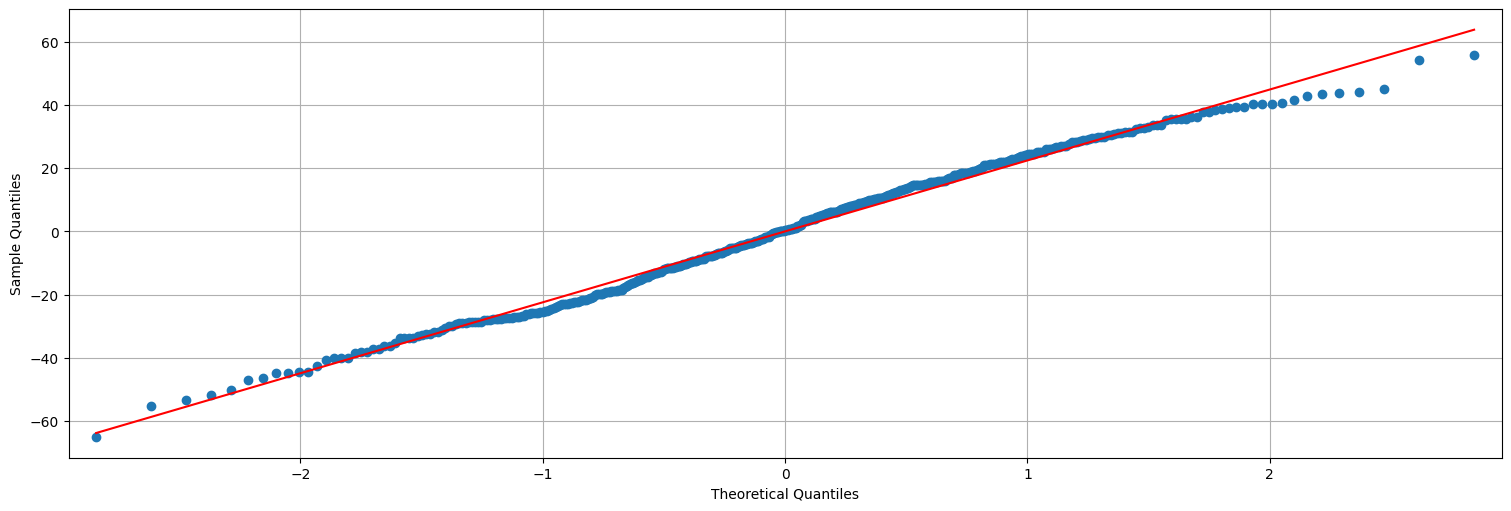

In [29]:
## QQ-plot es una verificación de gaussianidad.
sm.qqplot(fit.resid, line="s");

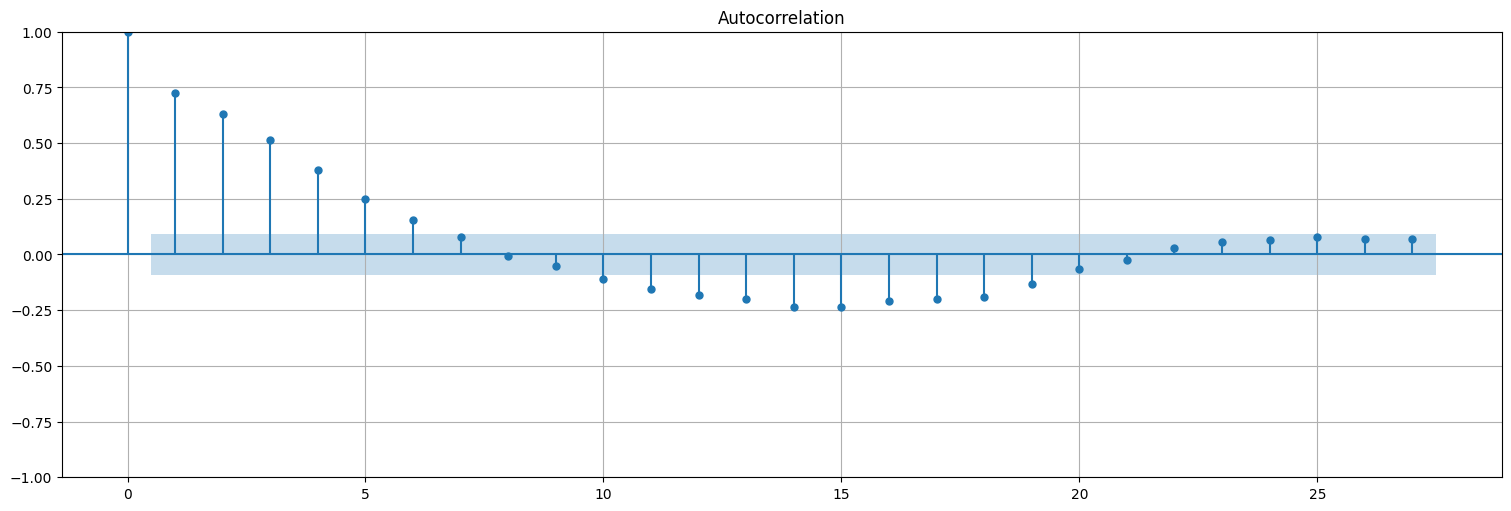

In [30]:
plot_acf(fit.resid, bartlett_confint=False);

### Mejorando el modelo

De la gráfica de $R_t$ vs. $S_{t-6}$ queda claro que el comportamiento es distinto dependiendo de si es positivo o negativo el valor de SOI. Podemos mejorar el modelo incluyendo una variable indicatriz para esto, es decir:

$$R_t = \beta_0 + \beta_1 S_{t-6} + \beta_2 D_{t-6} + \beta_3 S_{t-6}D_{t-6} + w_t$$

siendo $D_t = 1$ si $S_t>0$ y $0$ en otro caso. Esto es equivalente a ajustar dos rectas en las dos regiones.

In [31]:
dummy = soi>0
fish = pd.concat([rec, soi.shift(6), dummy.shift(6)], axis=1).dropna()
fish.columns = ["rec", "soiL6", "DL6"]

fit = ols("rec ~ soiL6+DL6+soiL6*DL6", data=fish).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    rec   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     99.43
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           3.20e-49
Time:                        17:02:43   Log-Likelihood:                -2010.7
No. Observations:                 447   AIC:                             4029.
Df Residuals:                     443   BIC:                             4046.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            74.4794      2.86

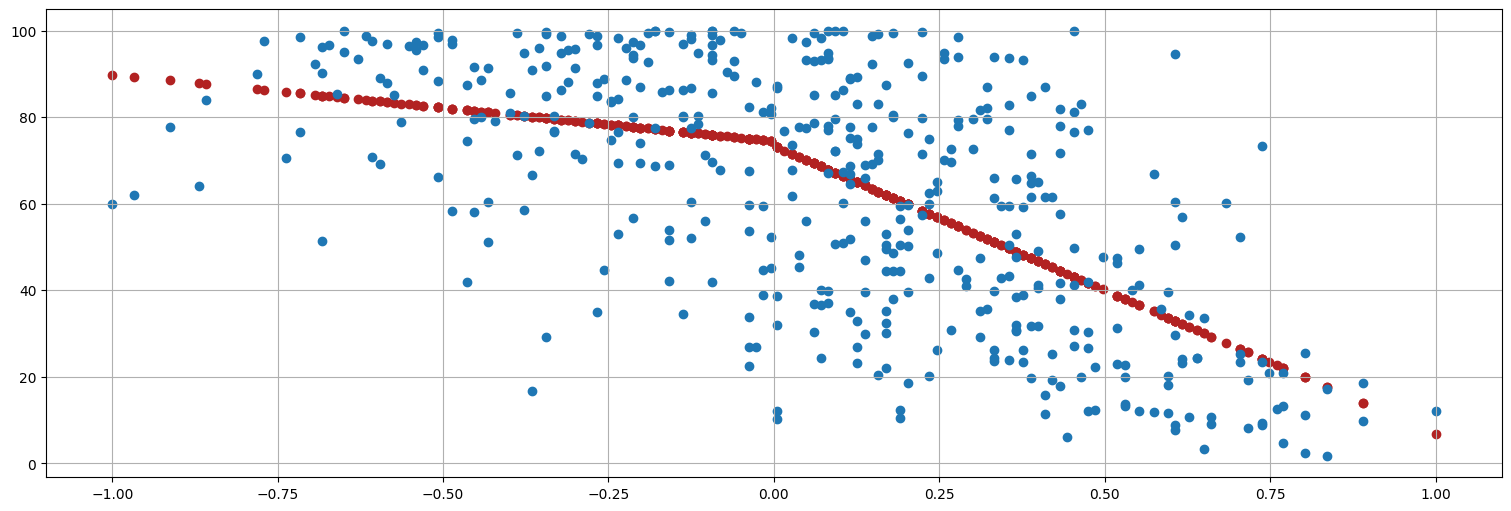

In [32]:
plt.scatter(fish.soiL6,fit.fittedvalues, color="firebrick")
plt.scatter(soi.shift(lag), rec);

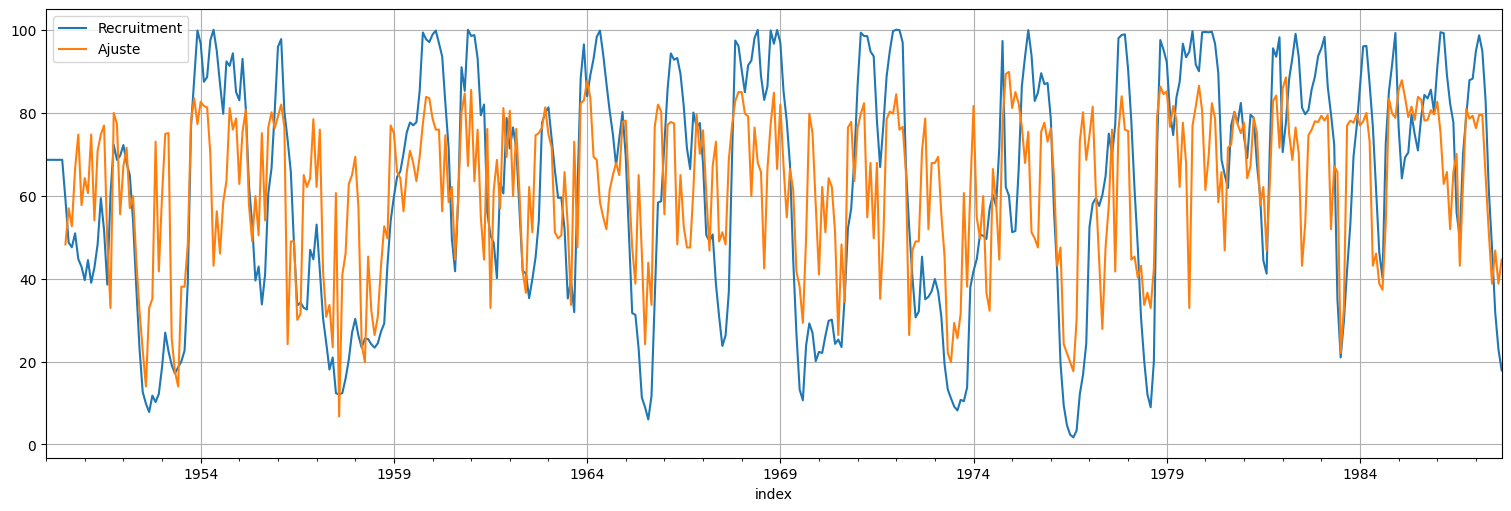

In [33]:
rec.plot()
fit.fittedvalues.plot().legend(["Recruitment","Ajuste"]);

### Análisis de residuos del ajuste

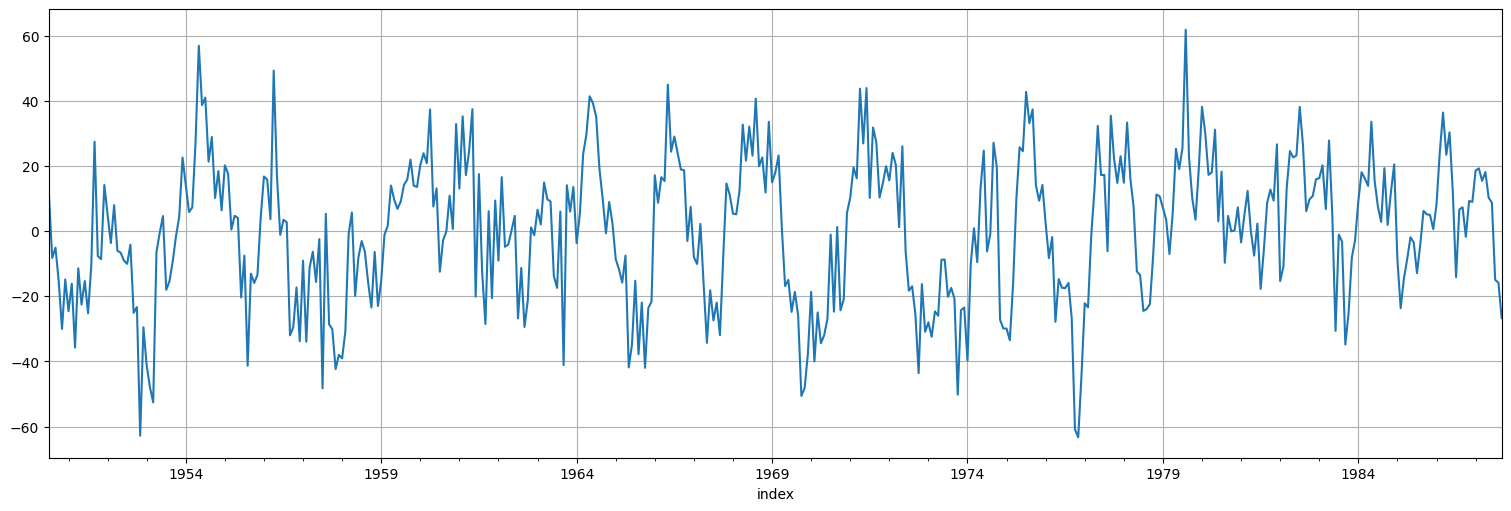

In [34]:
fit.resid.plot();

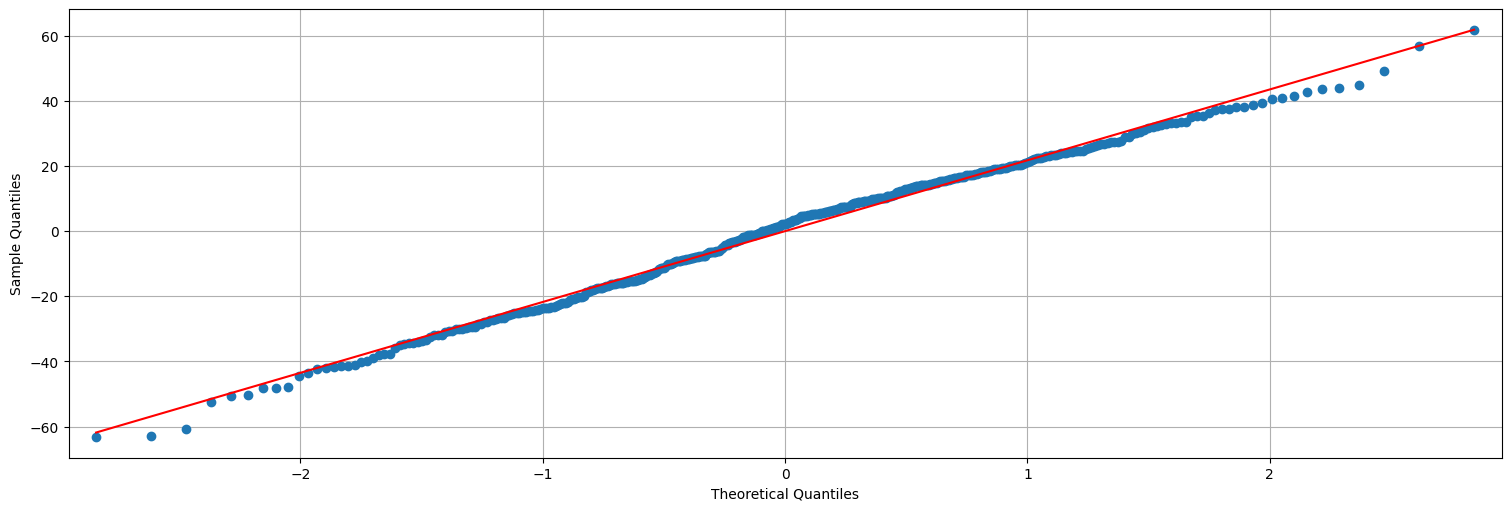

In [35]:
## QQ-plot es una verificación de gaussianidad.
sm.qqplot(fit.resid, line="s");

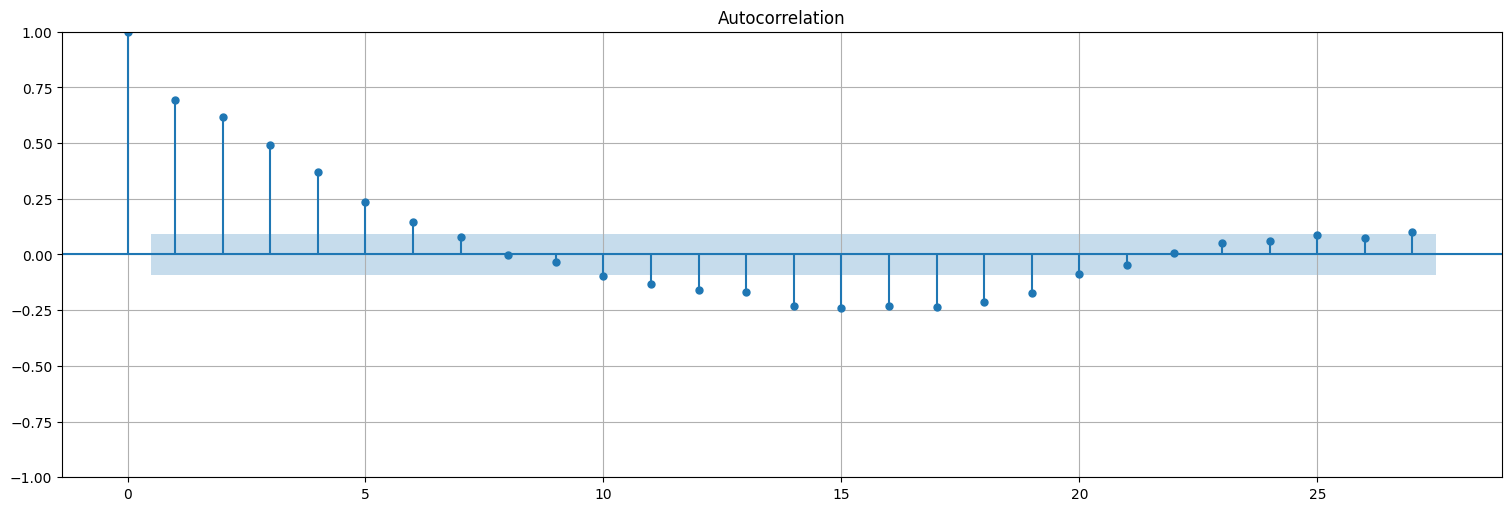

In [36]:
plot_acf(fit.resid, bartlett_confint=False);

## Componentes estacionales y periodograma

Otra de las componentes que nos gustaría analizar cuando exploramos un ajuste de serie temporal es la presencia de componentes periódicas.

**Ejemplos:**
 1. La mezcla de $\sin$ y $\cos$ del ejercicio del cuaderno pasado.
 2. El SOI visto más arriba (y el recruitement si le creemos al libro).

**Idea:** ¿Como sistematizar el encontrar componentes periódicas?

### Ejemplo: señal artificial (mezcla de $\sin$ y $\cos$)

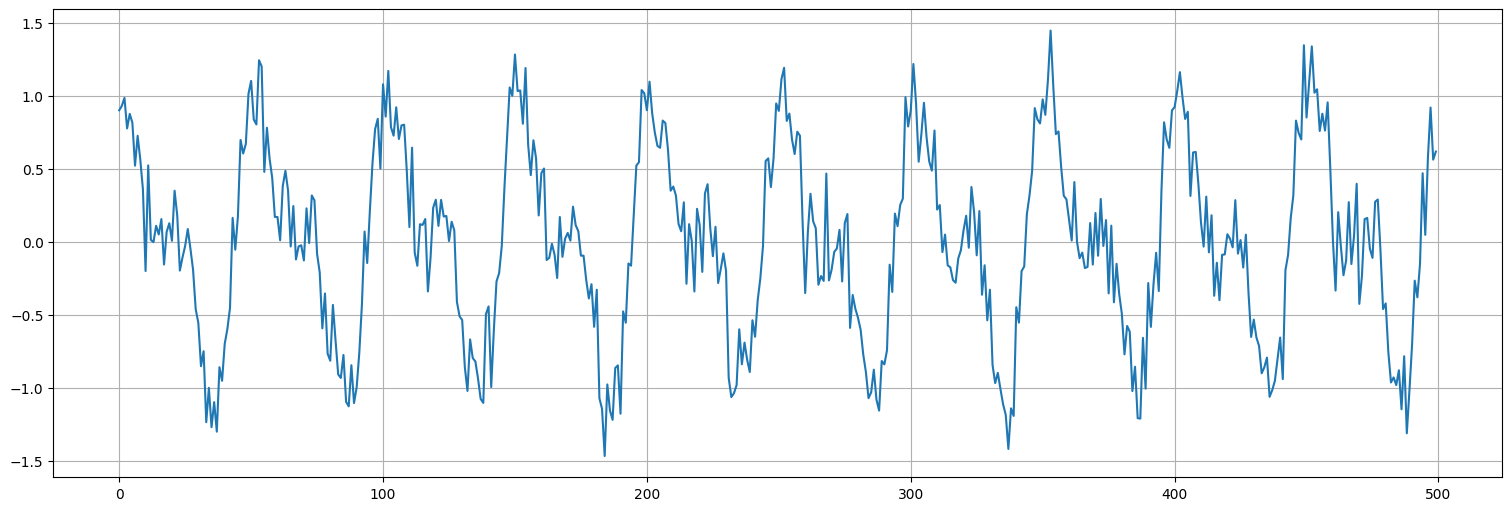

In [37]:
t=np.arange(0,500)
f=1/50 #frecuencia fundamental
signal = 0.5*np.cos(2*np.pi*f*t) + 0.5*np.sin(2*np.pi*f*t) + 0.5*np.cos(2*np.pi*2*f*t)
noise = np.random.normal(size=t.size,loc=0,scale=0.2)

x = signal + noise

plt.plot(t,x);

### Idea 1:

Calcular la autocorrelación de la señal y ver si aparecen picos. Similar a lo hecho para el SOI arriba.

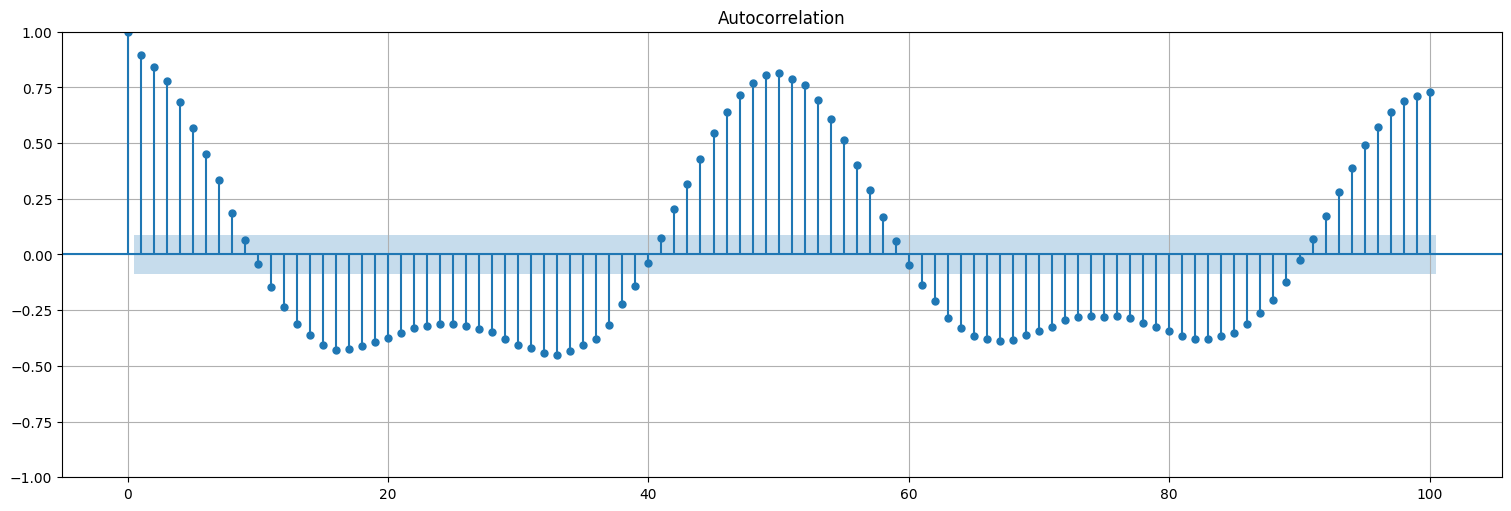

In [38]:
plot_acf(x, lags=100, bartlett_confint=False);

### Idea 2: correlacionar con una señal de frecuencia conocida

La idea es tomar señales de la forma:

$$ c^f_t = \cos(2\pi f t) \quad s^f_t = \sin(2 \pi f t).$$

Si el valor $P^f = \rho(x,c^f_t) ^2 + \rho(x,s^f_t)^2$ es alto, esa frecuencia está presente en la señal. Aqui $\rho$ indica correlación cruzada entre la señal y el $\cos/\sin$.

**Ejemplo:**

0.01515576431045041

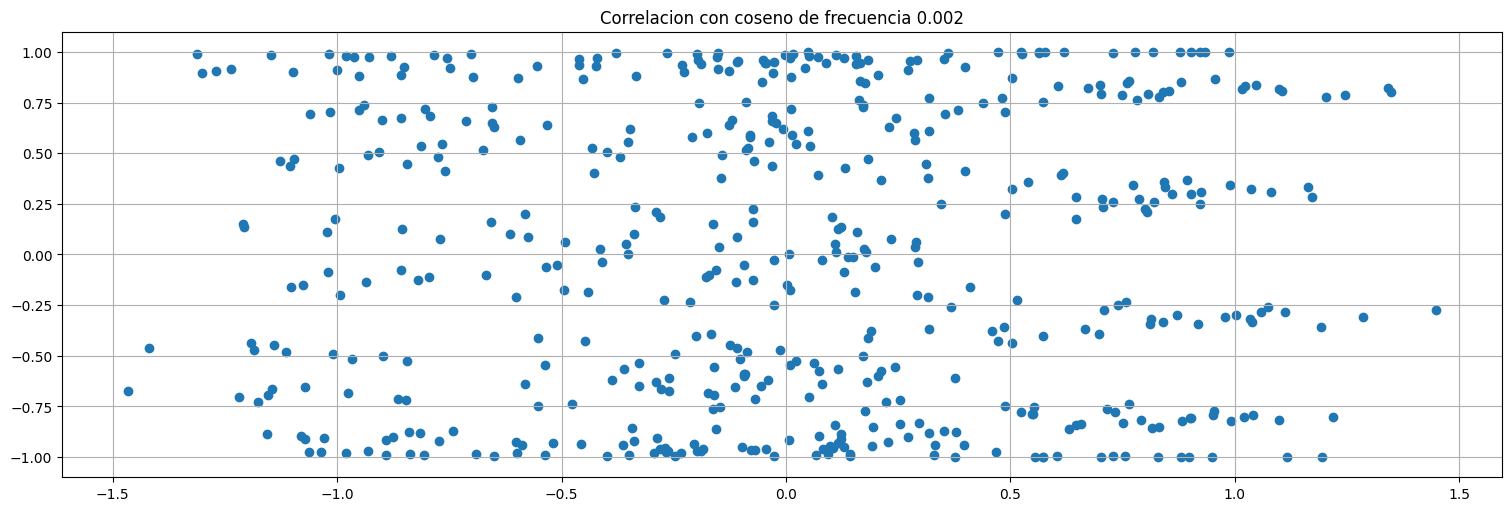

In [39]:
##ejemplo de lo que ocurre al variar la frecuencia
n=t.size      ##no. de muestras

#Probar con diferentes frecuencias:
f=1/500         # frecuencia a correlacionar. Si no está presente, no hay correlación.
#f=1/50          # frecuencia a correlacionar. Si está presente, hay correlación.
#f=1/25          # frecuencia a correlacionar. Si está presente, no hay correlación.

c1 = np.cos(2*np.pi*f*t)
plt.scatter(x,c1)
plt.title(f"Correlacion con coseno de frecuencia {f}")

np.corrcoef(x,c1)[0,1] #calculo la correlacion para mostrar

### Periodograma (transformada discreta de Fourier)

El *periodograma* es una forma sistemática de recorrer las correlaciones anteriores y calcular cuáles son significativas.

> **Definición:** Transformada Discreta de Fourier
>
> Dada una serie temporal $x_t$ de largo $n$ se define su DFT (Discrete Fourier Transform) como el vector complejo:
>  
> $$DFT_x(j/n) = \sum_{t} x_t \cos\left(2\pi \frac{j}{n} t\right) - i  \sum_{t} x_t \sin\left(2\pi \frac{j}{n} t\right) = \rho(x,c^{j/n}_t) - i \rho(x,s^{j/n}_t)

Es decir, $DFT_x$ guarda las covarianzas (correlaciones no escladas) con cosenos y senos de las frecuencias de la forma $j/n$ siendo $n$ la cantidad de datos.

Observar que el módulo $|DFT_x(j/n)|^2 = \rho(x,c^{j/n}_t) ^2 + \rho(x,s^{j/n}_t)^2$ nos da idea de la "fuerza" de esta frecuencia.

### El rol de $j$

La idea de la DFT es calcular sistemáticamente las correlaciones contra las frecuencias de la forma $j/n$, siendo $n$ el largo de los datos.

* $j=0$ correspondería a $\cos(0) \equiv 1$ y $\sin(0)\equiv 0$, que es lo mismo que sumar los datos. Es por ello que conviene *centrar* los datos antes de trabajar (eliminar la media).

* $0<j<n/2$ corresponde a las frecuencias observables. La interpretación de $j$ aquí es la cantidad de *ciclos* en la muestra que se presentan a dicha frecuencia.
  
  **Ejemplo:** En una serie de frecuencia anual ($12$ muestras por año) y $120$ observaciones ($10$ años), una componente anual debería aparecer para $j=10$ ($10$ ciclos en la muestra) o bien $j/n=10/120=1/12$.

* $j=n/2$ es la máxima frecuencia observable. ¿Por qué? Porque para poder "observar" adecuadamente una frecuencia necesitamos al menos dos muestras por ciclo. Si tenemos $n$ datos, dicha frecuencia máxima corresponde a $j=n/2$ ciclos en la muestra.

### FFT: Fast Fourier Transform

Numéricamente se calcula la $DFT$ usando el algoritmo FFT: Fast Fourier Transform, que reusa varios de los cálculos de correlación para una implementación más eficiente.

En `R`:
  * La FFT (DFT) se obtiene mediante `fft(x)`. 
  * Se calcula $I(j/n) = |DFT_x (j/n)|^2$, el módulo cuadrado del complejo resultante.
  * Luego se obtiene el Periodograma $P$ escalado definido como:
      $$P(j/n) = \frac{4}{n^2} I(j/n) = , \quad j=0,\ldots,n/2.$$
      El coeficiente $4/n^2$ lleva la escala a los coeficientes de regresión contra seno y coseno.
  * Si se desea graficar el periodograma $P$ en las frecuencias originales de la serie, se debe usar en las abscisas el vector de frecuencias:
      
      `f = [0, 1/n, 2/n, ..., (n/2-1)/n] * freq`

    siendo `freq` la frecuencia de la serie (frecuencia de muestreo).

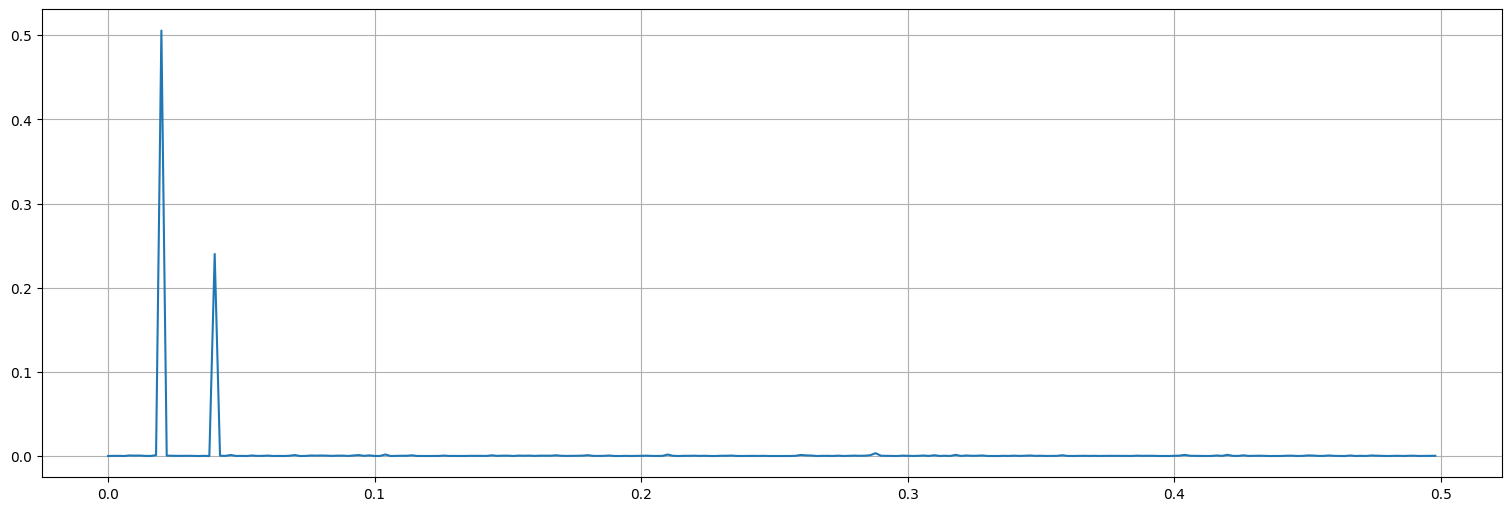

In [40]:
P = 4/n**2 * np.abs(np.fft.fft(x))**2
P = P[0:round(n/2)]
f = np.arange(0,n/2)/n

plt.plot(f,P);

#### Observación

Notar que las alturas del periodograma guardan relación con los coeficientes de seno y coseno involucrados en la señal.

## Aplicación:

Apliquemos la idea del periodograma al SOI y al Recruitement.

### Importante: 

Como ya mencionamos, antes de calcular el periodograma, debemos centrar la serie.

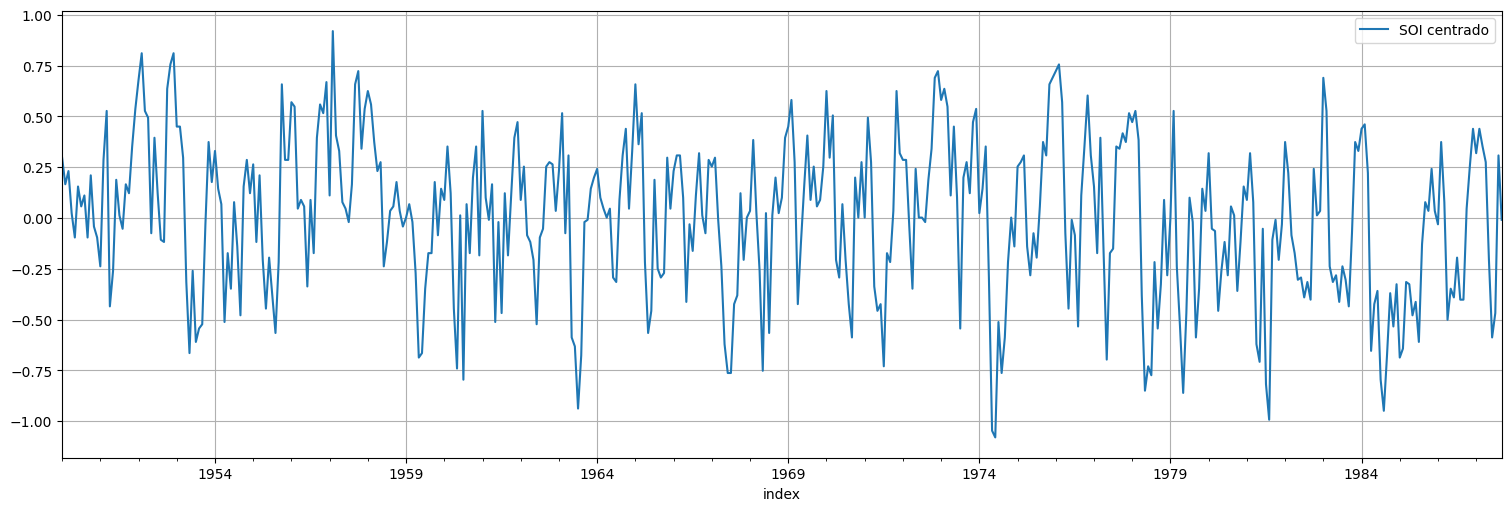

In [41]:
s = soi-np.mean(soi)       #lo centro
n=s.size
s.plot().legend(["SOI centrado"]);

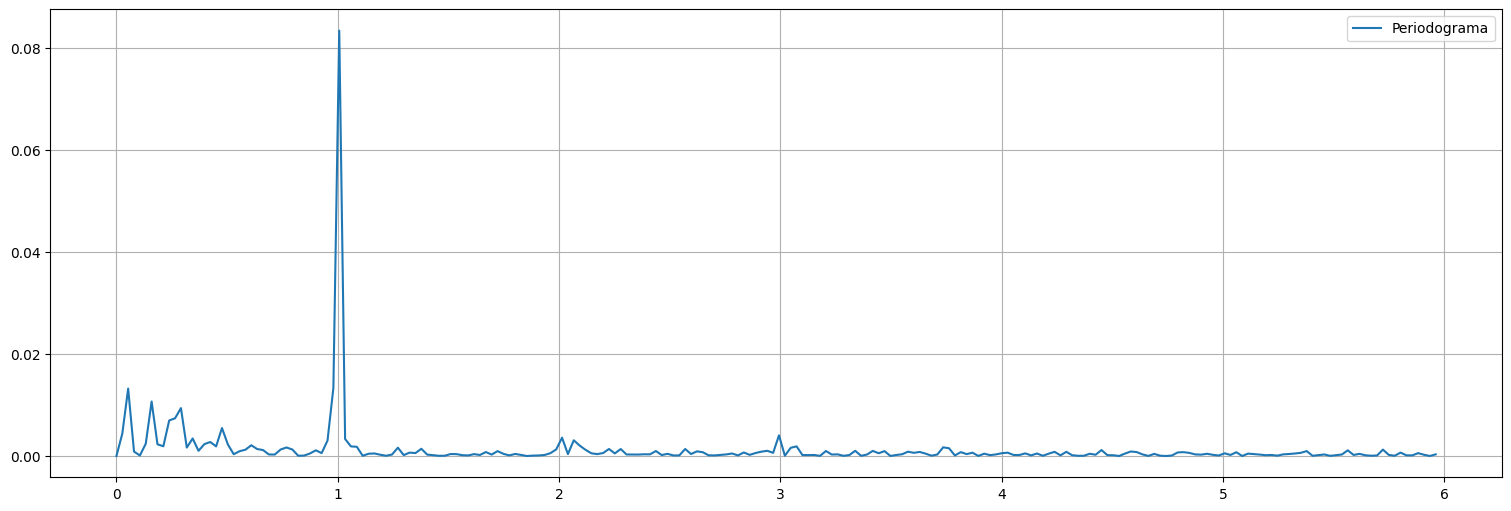

In [42]:
P = 4/n**2 * np.abs(np.fft.fft(s["value"]))**2
P = P[0:round(n/2)]
f = np.arange(0,n/2-1)/n*12

plt.plot(f,P)
plt.legend(["Periodograma"]);

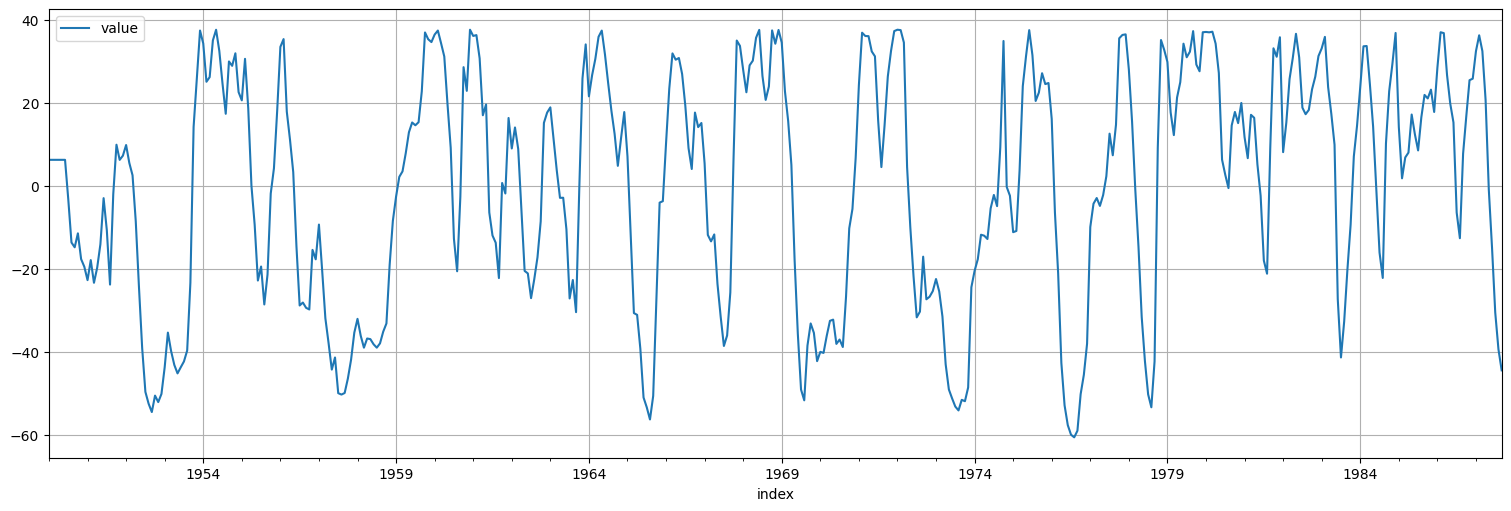

In [43]:
r = rec-np.mean(rec)       #lo centro
n=r.size
r.plot();

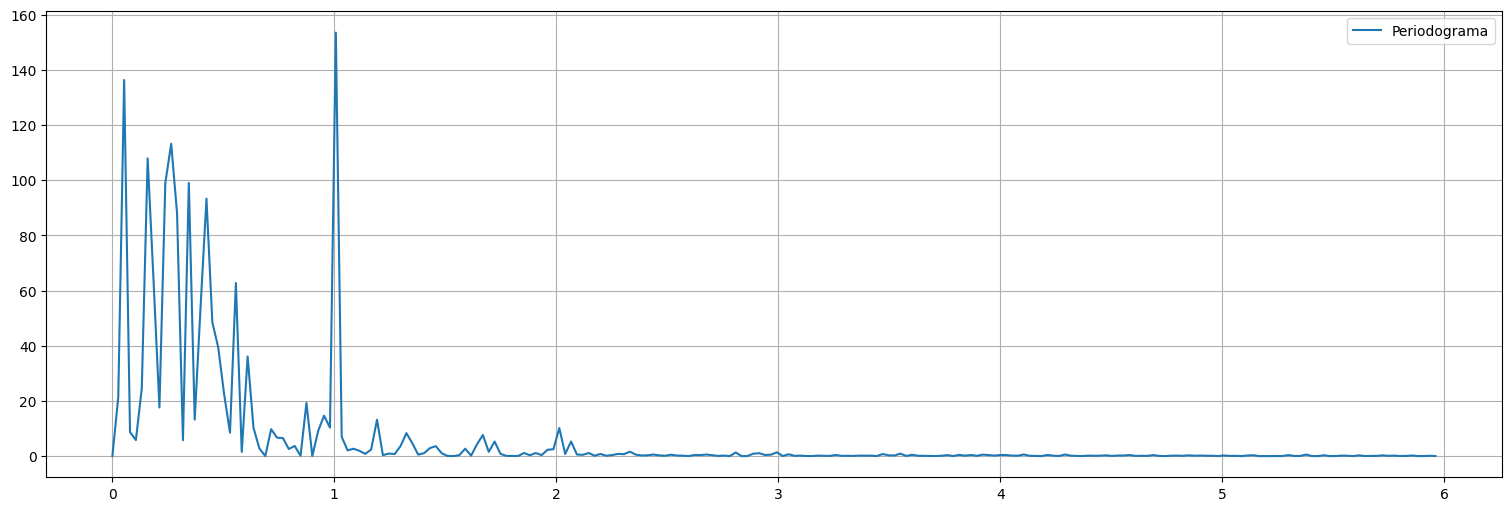

In [44]:
P = 4/n**2 * np.abs(np.fft.fft(r["value"]))**2
P = P[0:round(n/2)]
f = np.arange(0,n/2-1)/n*12

plt.plot(f,P);
plt.legend(["Periodograma"]);

### Observaciones

* La frecuencia anual aparece en el periodograma (el pico es en  $j=38$, cuando la muestra tiene casi $38$ años de datos precisamente). No era clara en la correlación en el caso de `rec` pero aquí sí se observa claramente.
* Aparecen frecuencias *más lentas*, tanto en `soi` como en `rec`. En el caso de `rec` aparecen varios picos en frecuencias casi contiguas, de períodos mayores a un año.
* No siempre los picos son todos relevantes. A veces es necesario *suavizar* el periodograma para extraer las frecuencias relevantes.
* Por ejemplo, aparecen picos cercanos a $f=0.25$ que corresponden con el ciclo el fenómeno del Niño (cada 4 años).

## Regresión no lineal

Cuando el modelo es no lineal, ¿qué podemos hacer?

**Ejemplo:** En el caso de la combinación de $\sin$ y $\cos$ ya sabíamos la frecuencia, pero si la dejamos libre el modelo:

$$x_t = \beta_1 \cos(2\pi f t) + \beta_2 \sin(2\pi f t)$$

pasa a ser no lineal, con parámetros $\theta=(\beta_1,\beta_2,f)$.

**Ejemplo (Crecimiento logístico):** En estudio de poblaciones, muchas veces es útil ajustar un modelo de la forma:
$$f(t;\theta) = \frac{A}{1+e^{-b(t-t_0)}}$$
siendo los parámetros en este caso $\theta=(A,b,t_0)$.

### Idea: aplicar el mismo criterio de mínimos cuadrados

Es decir si tengo una función no lineal de los parámetros desconocidos $y_t(\theta)$, buscamos resolver:

$$\min_\theta \sum_{t=1}^n (x_t - y_t(\theta))^2$$

**Problema:** la optimización anterior no necesariamente es fácil de hacer. No hay garantías de convexidad, puede tener mínimos locales.

El algoritmo más utilizado para resolver el problema anterior es el de *Gauss-Newton* que converge a un mínimo local. Si tenemos una buena aproximación inicial de la solución converge.

En R, esto se hace mediante la función `nls`.

### Ejemplo:

Analicemos los ingresos a CTI por COVID en Uruguay en el período 15/3 -- 30/4.

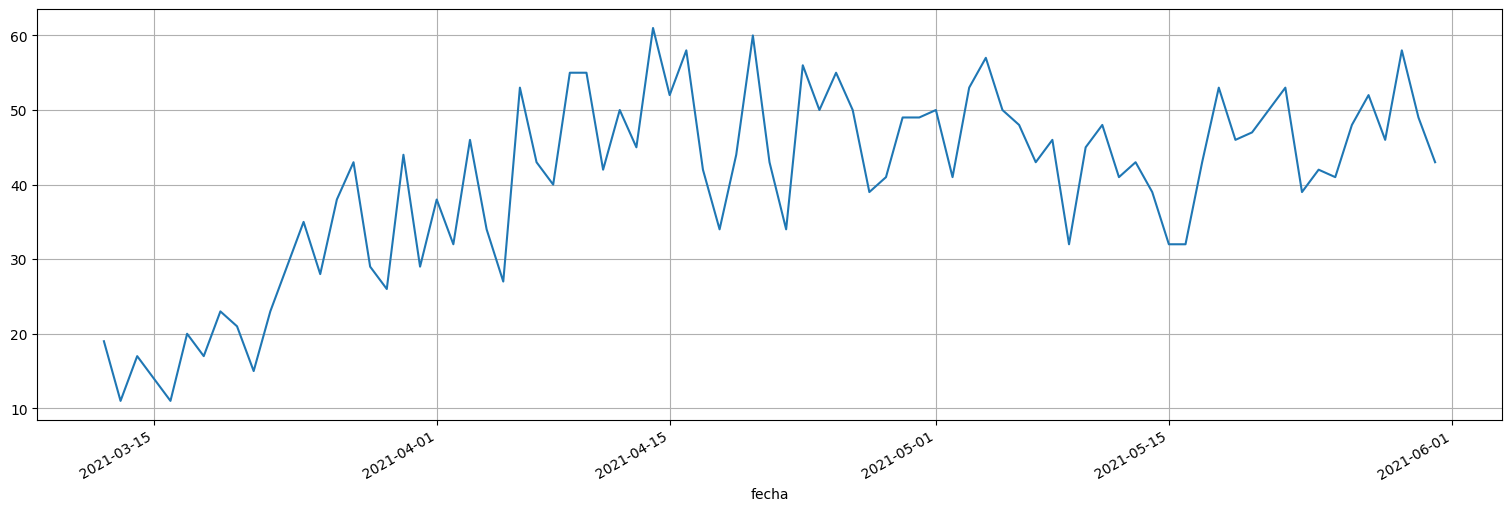

In [45]:
datos = pd.read_csv("https://raw.githubusercontent.com/GUIAD-COVID/datos-y-visualizaciones-GUIAD/master/datos/estadisticasUY_cti.csv", header=0,
                    index_col=[1], parse_dates=[1], date_format="%d/%m/%Y")
cti = datos["ingresos"].iloc[40:120]
cti.plot();

### Modelo:

Proponemos el siguiente modelo no lineal para ajustar una "meseta":

$$f(t,\theta) = a + b e^{-ct},$$

siendo $\theta = (a,b,c)$.

In [46]:
def f(theta, t):
    return theta[0] + theta[1]*np.exp(- theta[2] * t)

ts = np.arange(0,cti.size)
ys = cti.values

def residuos(theta):
    return f(theta, ts) - ys

In [47]:
from scipy.optimize import least_squares
theta0 = [50,-50,0.1]
fit = least_squares(residuos, theta0)

In [48]:
fit

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.095e+01  4.504e-02 ... -1.880e+00  4.126e+00]
           x: [ 4.720e+01 -3.915e+01  7.958e-02]
        cost: 2136.551873144035
         jac: [[ 1.000e+00  1.000e+00  0.000e+00]
               [ 1.000e+00  9.235e-01  3.615e+01]
               ...
               [ 1.000e+00  2.015e-03  6.151e+00]
               [ 1.000e+00  1.860e-03  5.754e+00]]
        grad: [-5.271e-06 -6.344e-07  9.777e-01]
  optimality: 0.9777335412868524
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 11
        njev: 11

In [49]:
a = fit.x[0]
b = fit.x[1]
c = fit.x[2]
loss = 2*fit.cost/ys.size

print("Coeficientes estimados:")
print(f"a = {a}")
print(f"b = {b}")
print(f"c = {c}")
print(f"Mean square error: {loss}")

Coeficientes estimados:
a = 47.1984839686561
b = -39.14817489224575
c = 0.07958170723785155
Mean square error: 53.41379682860088


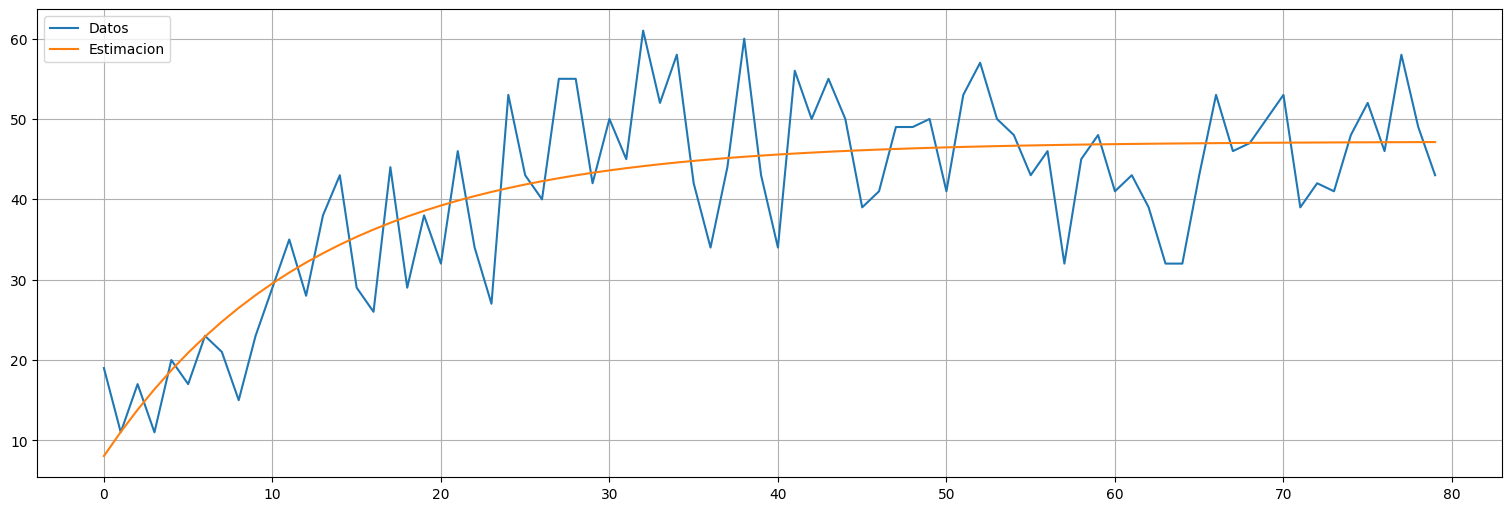

In [50]:
plt.plot(ts,ys, label="Datos");
plt.plot(ts,f(fit.x,ts), label="Estimacion")
plt.legend();

53.41379682860088

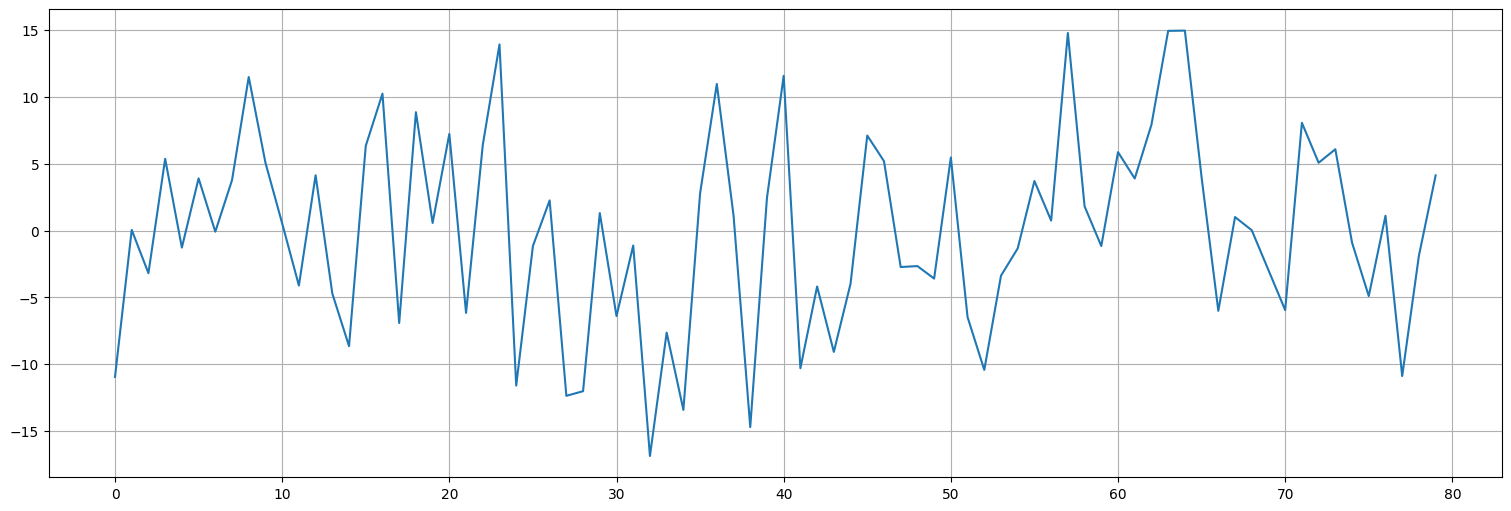

In [51]:
residuos = fit.fun
plt.plot(ts,residuos);
np.var(residuos)

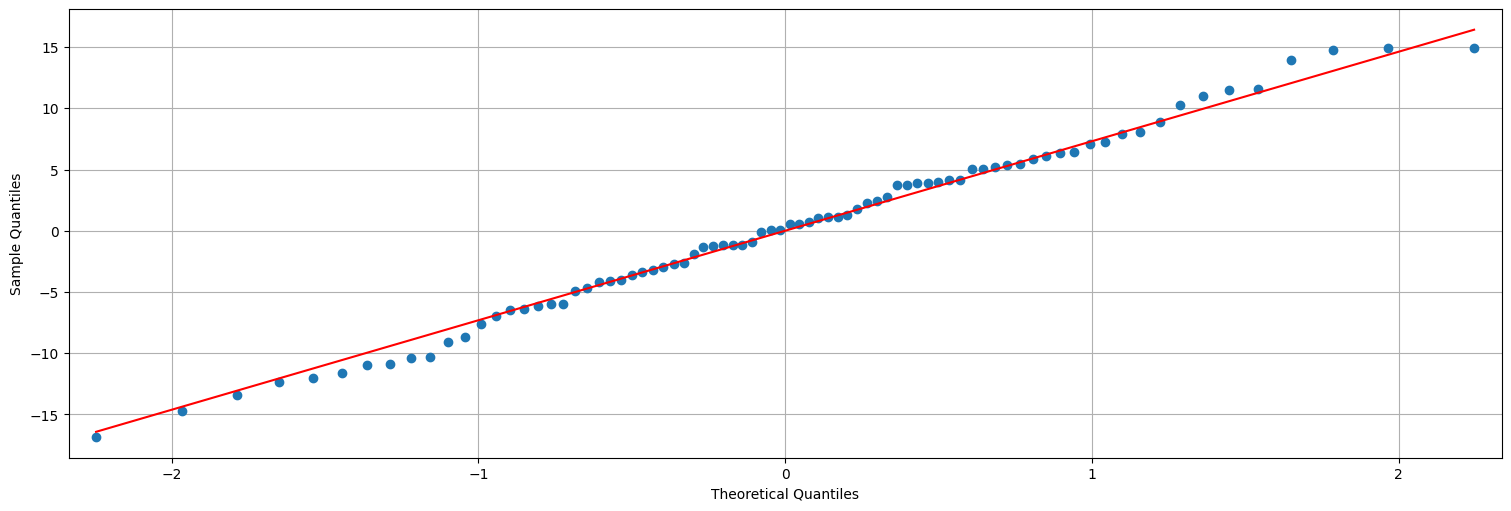

In [52]:
sm.qqplot(residuos, line="s");

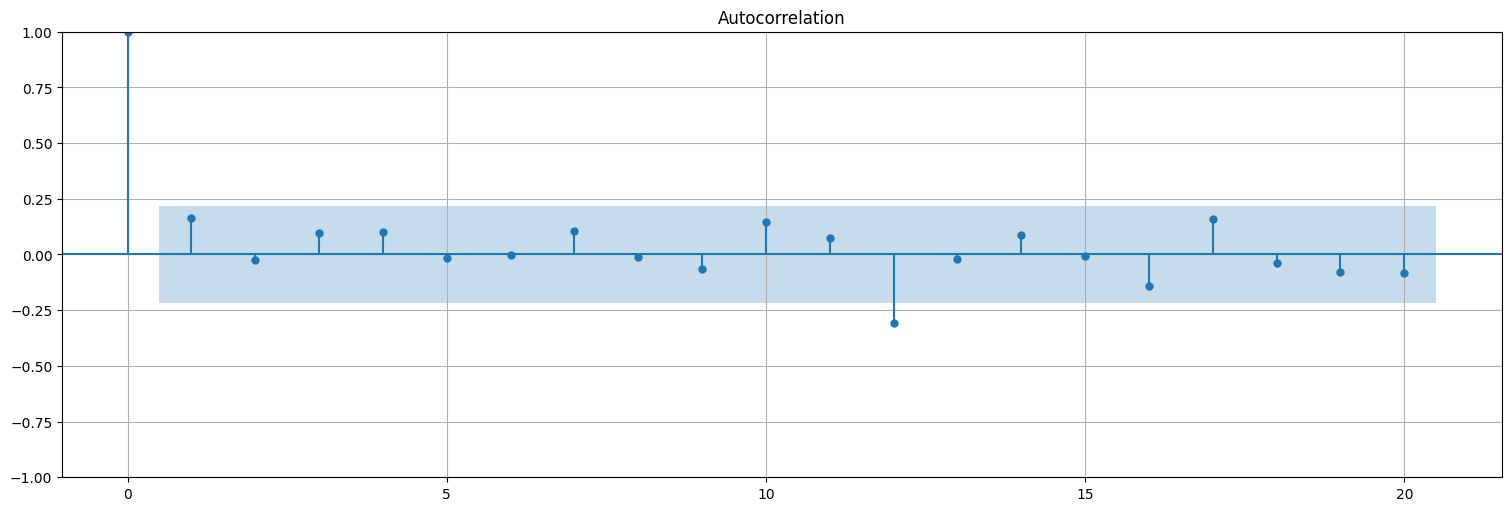

In [53]:
plot_acf(residuos, bartlett_confint=False);

In [54]:
#Calculo el R^2
n=cti.size

RSS = np.sum(residuos**2)/n
SSE = np.sum((cti-np.mean(cti))**2)/n
R2 = (SSE-RSS)/SSE

print(f"RSS = {RSS}");
print(f"SSE = {SSE}");
print(f"R2 = {R2}");


RSS = 53.41379682860088
SSE = 142.82734375
R2 = 0.6260254134383783


## Ejercicio

En este ejercicio, se busca explorar la naturaleza periódica de $S_t$, la serie SOI ya analizada.

1. Quitar la tendencia a las serie mediante una regresión lineal en la componente tiempo. ¿Hay una tendencia significativa en la temperatura de superficie?

2. Calcular el periodograma para la serie sin tendencia (residuos) de la parte anterior. Identificar las frecuencias principales (una obvia es la anual). ¿Cuál es el ciclo probable del fenómeno del Niño que refleja el pico más pequeño?


## Ejercicio

Considere las dos series semanales `oil` (precio del petróleo) and `gas` (precio del combustible). La primera está en dólares por barril, la segunda en centavos por galón.

1. Graficar ambas en una misma gráfica. ¿Cuál de los modelos ya vistos se asemeja más? ¿Son estacionarias?

2. En economía, muchas veces la información se encuentra en el porcentaje de cambio de la serie (retorno o tasa de crecimiento). Argumente que la transformación $y_t= \log(x_t) - \log(x_{t-1})$ puede usarse para obtener el retorno.

3. Aplicar la transformación a las series anteriores, volver a graficar y analizar la autocorrelación de las mismas.

4. Graficar la correlación cruzada de las series transformadas. Los valores pequeños pero significativos donde gas adelanta a oil pueden ser considerados "realimentación" entre ellas.

5. Realizar nubes de puntos para las series laggeadas, con hasta 3 semanas de diferencia.

6. Hay estudios que afirman que los precios de combustible responden más rápido a las subidas del petróleo que a las bajadas. Para explorar esto hagamos una regresión con lags simple. 

Sean $G_t$ y $O_t$ las series transformadas de gas y oil respectivamente. Ajuste una regresión:

$$G_t = \alpha_1 + \alpha_2 I_t + \beta_1 O_t + \beta_2 O_{t−1} + w_t,$$

siendo $I_t = 1$ si $O_t \geqslant 0$ y $0$ si no ($I_t$ representa si oil está creciendo). Sugerencia: construir $I$ como `indi = ifelse(poil < 0, 0, 1)`

Analizar y discutir los resultados.

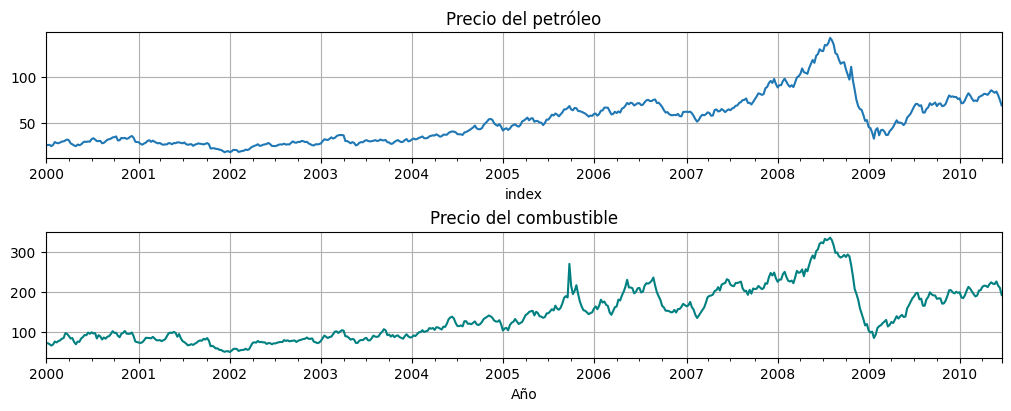

In [55]:
oil=astsa.oil
gas=astsa.gas


fig, axs = plt.subplots(2, 1, figsize=[10,4])
oil.plot(ax=axs[0], title="Precio del petróleo", legend=False)
gas.plot(ax=axs[1], title="Precio del combustible", color="teal", xlabel="Año", legend=False);

## Ejercicio

Analizar el uso de la función `nls` para hacer una ajuste de curva logística a la serie de poblaciones de Australia entre 1778 y 2005 almacenada en `data/au_population.csv`.

La función logística de parámetros $A$, $b$ y $t_0$ tiene la siguiente expresión:

$$f(t;A,b,t_0) = \frac{A}{1+e^{-b(t-t_0)}}$$

Los parámetros representan:
* $A$: el valor asintótico.
* $b$: la velocidad de transición de $0$ a $A$.
* $t_0$: el tiempo de transición (donde vale $A/2$).


In [56]:
pop = pd.read_csv("../data/au_population.csv", header=0,
                    index_col=[0], parse_dates=[0], date_format="%Y")
pop = pop/1e6
pop.T

year        1788-01-01  1789-01-01  1790-01-01  1791-01-01  1792-01-01  \
population    0.000859    0.000645    0.002056    0.002873    0.003264   

year        1793-01-01  1794-01-01  1795-01-01  1796-01-01  1797-01-01  ...  \
population    0.003514    0.003579    0.003466      0.0041    0.004344  ...   

year        1996-01-01  1997-01-01  1998-01-01  1999-01-01  2000-01-01  \
population    18.42032   18.609115   18.814276   19.038338   19.272644   

year        2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  
population   19.533972   19.770963   20.011882   20.252132   20.544064  

[1 rows x 218 columns]

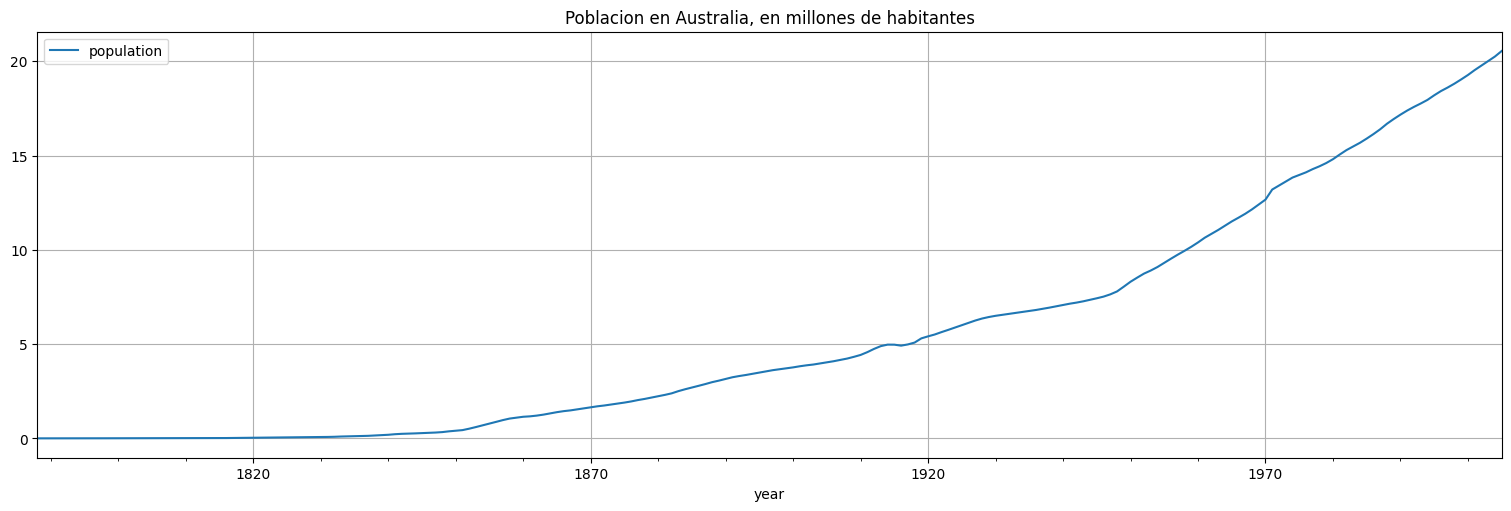

In [57]:
pop.plot(title="Poblacion en Australia, en millones de habitantes");